# Histological Features Analysis

In this notebook, I focus on the analysis of histological features extracted from tissue images, integrated with spatial and transcriptomic data.  
The main questions are:

- Are the Unknown cells more similar to Malignant or Normal cells?
- Are histological data and molecular data complementary? 
- Why do the cells reclassified as Unknown ⟶ Malignant have both signatures lower?
- Are there molecular markers for the histological subclusters?

The goal is to assess whether histological features, such as combinations of texture, cellular organization, and microenvironment structure, can improve cell classification and whether they provide complementary insights to those obtained from molecular features.


## Library Imports
This section imports the libraries required for the analysis:

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
# System & OS utilities
import os
os.makedirs('results/DGE', exist_ok=True)
os.makedirs('figures/DGE_rank_genes', exist_ok=True)
os.makedirs('figures/DGE_dotplot', exist_ok=True)

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Single-cell & spatial data
import scanpy as sc
import spatialdata as sd
import cellcharter as cc

# Machine learning & stats
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, accuracy_score, normalized_mutual_info_score, cohen_kappa_score, classification_report, confusion_matrix

## Dataset Loading

In this section, the datasets used for the analysis are loaded:

- **Xenium_V1_FFPE_Human_Breast_IDC.zarr** (referred to as *xenium*): the full spatial transcriptomics dataset.  
- **epithelial_cells**: a subset of *xenium* containing only epithelial cells, on which the downstream analyses are focused.  
- **molecular_single_features**: features derived from gene expression measurements in each epithelial cell, representing the molecular profile of the cell.  
- **histological_single_features**: histological features automatically extracted from immagini H&E tramite il modello iBOT ViT-Base.

In [3]:
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

In [4]:
epithelial_cells = sc.read_h5ad("epithelial_cells_cell_type_prediction_filtered.h5ad")

In [5]:
molecular_single_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_molecular_epithelial.csv")

In [6]:
histological_single_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_histology_epithelial.csv")

## Adding Features

Molecular and histological features are added to their respective `AnnData` objects in the `.obsm` attribute to facilitate their use in clustering and visualization analyses.

In [7]:
def create_feature_anndata(epithelial_cells, feature_df, obsm_key):
    # If 'cell_id' is a column, use it as the index
    if "cell_id" in feature_df.columns:
        feature_df = feature_df.set_index("cell_id")

    # Convert to string to align
    obs_ids = epithelial_cells.obs['cell_id'].astype(str)
    feature_df.index = feature_df.index.astype(str)

    # Find common cells
    common_cells = obs_ids[obs_ids.isin(feature_df.index)]
    adata_filtered = epithelial_cells[common_cells.index].copy()

    # Align features in the correct order
    feature_aligned = feature_df.loc[common_cells]

    # Insert features
    adata_filtered.obsm[obsm_key] = feature_aligned.astype("float32").to_numpy()
    adata_filtered.uns[obsm_key + "_feature_names"] = feature_aligned.columns.tolist()

    print(f"Features added to `{obsm_key}`. {adata_filtered.n_obs} cells, {feature_aligned.shape[1]} features.")
    return adata_filtered

# SINGLE FEATURES = XENIUM-SPECIFIC FEATURES ONLY FOR EPITHELIAL CELLS
adata_molecular_single_features = create_feature_anndata(epithelial_cells, molecular_single_features, "molecular_single_features")
adata_histological_single_features = create_feature_anndata(epithelial_cells, histological_single_features, "histological_single_features")

Features added to `molecular_single_features`. 348692 cells, 10 features.
Features added to `histological_single_features`. 348692 cells, 10 features.


## Downsampling

To ensure comparability across cell types, I downsample each group to the same number of cells (25,000 Malignant, 25,000 Normal, and all Unknown cells), using a fixed seed (42) for reproducibility. This step is important because GMM clustering is sensitive to imbalanced datasets.

In [8]:
def downsample_adata(adata, label_key="cell_type_prediction", n_per_class=25000, seed=42):
    rng = np.random.default_rng(seed)  # inizializzo il generatore con seed
    idxs = []
    for cat in adata.obs[label_key].unique():
        cat_idx = np.where(adata.obs[label_key] == cat)[0]
        if len(cat_idx) > n_per_class:
            chosen = rng.choice(cat_idx, n_per_class, replace=False)  
        else:
            chosen = cat_idx
        idxs.extend(chosen)
    
    return adata[idxs].copy()

adata_molecular_single_features_down = downsample_adata(adata_molecular_single_features, n_per_class=25000, seed=42)
adata_histological_single_features_down = downsample_adata(adata_histological_single_features, n_per_class=25000, seed=42)

## Unsupervised Clustering with ClusterAutoK

The `ClusterAutoK` method is applied to automatically identify the optimal number of clusters, using both scaled and unscaled features.  
The analyses are performed separately for:  
- **Molecular features** (`molecular_single_features`)  
- **Histological features** (`histological_single_features`)  

For each analysis, a cluster stability plot is generated to support the selection of the most robust number of clusters. The fitted model is then saved for downstream analyses. ClusterAutoK is an unsupervised clustering method, meaning it does not use pre-assigned labels. It selects the optimal number of clusters based on internal metrics of cluster quality and stability, making it suitable for exploring structure in high-dimensional molecular or histological data.

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

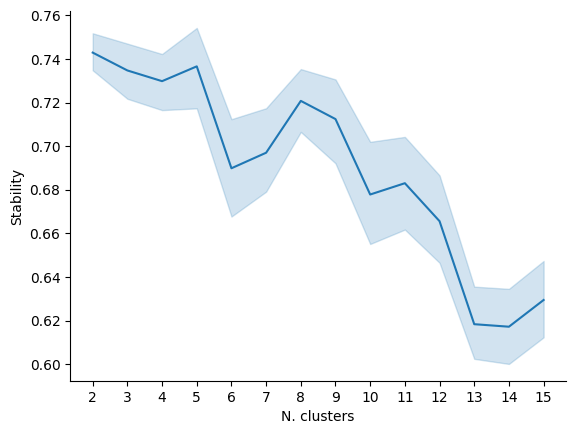

In [747]:
# ClusterAutoK on UNSCALED MOLECULAR SINGLE FEATURES DOWN k=5

autok_molecular_single_features_unscaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15), 
    max_runs=10,
    convergence_tol=0.001)

autok_molecular_single_features_unscaled.fit(
    adata_molecular_single_features_down, 
    use_rep='molecular_single_features')

# Visualize cluster stability
ax = cc.pl.autok_stability(autok_molecular_single_features_unscaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "molecular_single_features_unscaled_autok_plot.pdf", dpi=300)

# Save the model
save_path = Path("saved_models_final/molecular_single_features_unscaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_molecular_single_features_unscaled.save(save_path, best_k=False)

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

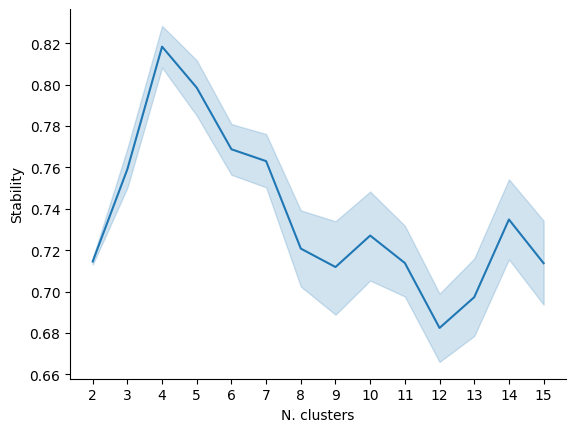

In [741]:
# ClusterAutoK on UNSCALED HISTOLOGICAL SINGLE FEATURES DOWN k=4

autok_histological_single_features_unscaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15),
    max_runs=10,
    convergence_tol=0.001)

autok_histological_single_features_unscaled.fit(
    adata_histological_single_features_down,
    use_rep='histological_single_features')

# Visualize cluster stability
ax = cc.pl.autok_stability(autok_histological_single_features_unscaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "histological_single_features_unscaled_autok_plot.pdf", dpi=300)

# Save the model
save_path = Path("saved_models_final/histological_single_features_unscaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_histological_single_features_unscaled.save(save_path, best_k=False)

## Feature Standardization

Features are scaled using `StandardScaler` to normalize the variance across variables. This step is crucial to prevent features with different ranges from disproportionately influencing the clustering. The scaled data are saved in new .obsm matrices, preserving the original unscaled versions for comparison.

In [9]:
def standardize_features(adata, obsm_key, new_obsm_key):
    scaler = StandardScaler()
    X = adata.obsm[obsm_key]
    X_scaled = scaler.fit_transform(X)
    adata.obsm[new_obsm_key] = X_scaled
    return adata

adata_molecular_single_features_down = standardize_features(
    adata_molecular_single_features_down,
    obsm_key="molecular_single_features",
    new_obsm_key="molecular_single_features_scaled")

adata_histological_single_features_down = standardize_features(
    adata_histological_single_features_down,
    obsm_key="histological_single_features",
    new_obsm_key="histological_single_features_scaled")

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

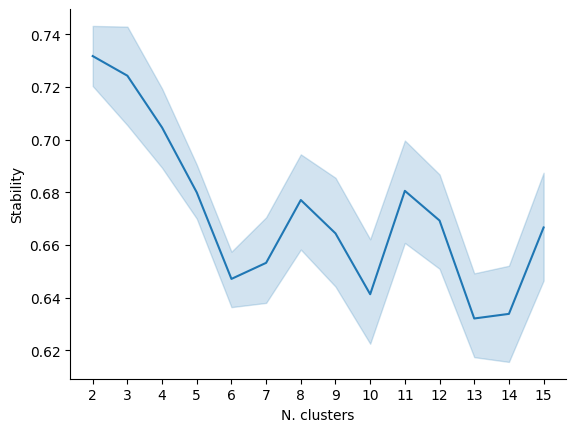

In [748]:
# ClusterAutoK on SCALED MOLECULAR SINGLE FEATURES DOWN k=2

autok_molecular_single_features_scaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15),
    max_runs=10,
    convergence_tol=0.001)

autok_molecular_single_features_scaled.fit(
    adata_molecular_single_features_down, 
    use_rep='molecular_single_features_scaled')

# Visualize cluster stability
ax = cc.pl.autok_stability(autok_molecular_single_features_scaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "molecular_single_features_scaled_autok_plot.pdf", dpi=300)

# Save the model
save_path = Path("saved_models_final/molecular_single_features_scaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_molecular_single_features_scaled.save(save_path, best_k=False)

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

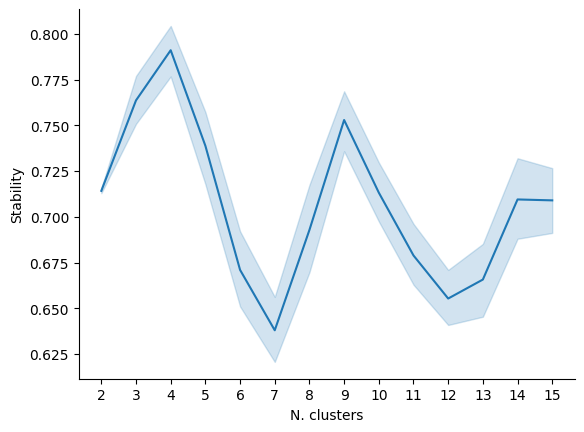

In [743]:
# ClusterAutoK on SCALED HISTOLOGICAL SINGLE FEATURES k=4

autok_histological_single_features_scaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15),
    max_runs=10,
    convergence_tol=0.001)

autok_histological_single_features_scaled.fit(
    adata_histological_single_features_down,
    use_rep='histological_single_features_scaled')

# Visualize cluster stability
ax = cc.pl.autok_stability(autok_histological_single_features_scaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "histological_single_features_scaled_autok_plot.pdf", dpi=300)

# Save the model
save_path = Path("saved_models_final/histological_single_features_scaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_histological_single_features_scaled.save(save_path, best_k=False)

## Loading Models and Predicting Clusters

Saved `ClusterAutoK` models are reloaded to assign final clusters to the AnnData objects. The assignments include:
Le assegnazioni includono:
- `cluster_5_unscaled` for unscaled molecular features
- `cluster_2_scaled` or scaled molecular features
- `cluster_4_unscaled` and `cluster_4_scaled` for histological features

These cluster assignments will be used to assess consistency across different domains (molecular vs. histological).

In [10]:
# MOLECULAR_SINGLE_FEATURES_DOWN_UNSCALED k=5     
autok_molecular_single_features_down_unscaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/molecular_single_features_unscaled_autok")
adata_molecular_single_features_down.obs['cluster_5_unscaled'] = autok_molecular_single_features_down_unscaled_loaded.predict(
    adata_molecular_single_features_down, use_rep='molecular_single_features', k=5)

# MOLECULAR_SINGLE_FEATURES_DOWN_SCALED k=2    
autok_molecular_single_features_down_scaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/molecular_single_features_scaled_autok")
adata_molecular_single_features_down.obs['cluster_2_scaled'] = autok_molecular_single_features_down_scaled_loaded.predict(
    adata_molecular_single_features_down, use_rep='molecular_single_features_scaled', k=2)


# HISTOLOGICAL_SINGLE_FEATURES_DOWN_UNSCALED k=4   
autok_histological_single_features_down_unscaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/histological_single_features_unscaled_autok")
adata_histological_single_features_down.obs['cluster_4_unscaled'] = autok_histological_single_features_down_unscaled_loaded.predict(
    adata_histological_single_features_down, use_rep='histological_single_features', k=4)

# HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED k=4   
autok_histological_single_features_down_scaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/histological_single_features_scaled_autok")
adata_histological_single_features_down.obs['cluster_4_scaled'] = autok_histological_single_features_down_scaled_loaded.predict(
    adata_histological_single_features_down, use_rep='histological_single_features_scaled', k=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
dataset_configs = {
    'HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED': {
        'adata': adata_histological_single_features_down,
        'n_comp': '4_scaled',
        'malignant_clusters': [0, 3],
        'normal_clusters': [1, 2]
    },
    'MOLECULAR_SINGLE_FEATURES_DOWN_SCALED': {
        'adata': adata_molecular_single_features_down,
        'n_comp': '2_scaled',
        'malignant_clusters': [1],
        'normal_clusters': [0]
    },
    'HISTOLOGICAL_SINGLE_FEATURES_DOWN_UNSCALED': {
        'adata': adata_histological_single_features_down,
        'n_comp': '4_unscaled',
        'malignant_clusters': [1, 2],
        'normal_clusters': [0, 3]
    },
    'MOLECULAR_SINGLE_FEATURES_DOWN_UNSCALED': {
        'adata': adata_molecular_single_features_down,
        'n_comp': '5_unscaled',
        'malignant_clusters': [0, 1, 4],
        'normal_clusters': [2, 3]
    }
}

## Cluster Reassignment Pipeline and Analysis of Unknown Groups
This section outlines the pipeline used to analyze clusters and reclassify Unknown cell groups. The main steps include:
- Compute global cell type percentages
- Calculate fold-changes for each cluster
- Visualize fold-changes using heatmaps
- Assign labels to clusters
- Reclassify Unknown cell groups
- Plot molecular signature distributions by group
- Assess cluster composition in percentages
- Analyze `total_counts` in Unknown groups

In [17]:
def full_pipeline(adata, cluster_col, malignant_clusters, normal_clusters, n_comp, output_prefix="dataset"):
    # CUSTOM PALETTE
    custom_palette = {
        'Unknown → Malignant': '#D94F4F',
        'Unknown → Normal': '#009E73',
        'Unknown (unchanged)': '#56B4E9',
        'Malignant (original)': '#D94F4F',
        'Normal (original)': '#009E73'
    }

    # FUNCTION FOR BOXPLOTS WITH MEANS
    def plot_counts_with_means(df, x_var, y_var='total_counts', order=None,
                               title='', palette='Set2', figsize=(7,5), save_path=None):
        plt.figure(figsize=figsize)
        ax = sns.boxplot(
            data=df,
            x=x_var,
            y=y_var,
            palette=palette if isinstance(palette, str) else [palette.get(cat, 'gray') for cat in order],
            order=order,
            showfliers=False
        )
        sns.stripplot(
            data=df,
            x=x_var,
            y=y_var,
            color='black',
            alpha=0.3,
            jitter=True,
            order=order,
            ax=ax
        )

        means = df.groupby(x_var)[y_var].mean()
        y_range = df[y_var].max() - df[y_var].min()

        for i, cat in enumerate(order):
            if cat in means.index:
                mean_val = means[cat]
                ax.hlines(mean_val, i - 0.35, i + 0.35, colors='black', linewidth=3)
                bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
                ax.text(i, mean_val + 0.07 * y_range, f"{mean_val:.1f}",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        color='black', bbox=bbox_props)

        plt.title(title)
        plt.xticks(rotation=45)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()
        plt.close()

    # UNIQUE COLUMN NAMES BASED ON N_COMP
    new_cluster_col = f"new_cluster_{n_comp}"
    reclassified_col = f"reclassified_cluster_{n_comp}"

    os.makedirs("figures", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    # GLOBAL PERCENTAGES
    cell_type_counts = adata.obs['cell_type_prediction'].value_counts()
    total_cells = cell_type_counts.sum()
    malignant_pct_total = (cell_type_counts.get('Malignant', 0) / total_cells) * 100
    normal_pct_total = (cell_type_counts.get('Normal', 0) / total_cells) * 100
    unknown_pct_total = (cell_type_counts.get('Unknown', 0) / total_cells) * 100

    # FOLD CHANGE PER CLUSTER
    cluster_counts = adata.obs.groupby([cluster_col, "cell_type_prediction"]).size().unstack(fill_value=0)
    cluster_counts["Total"] = cluster_counts.sum(axis=1)
    for ctype in ['Malignant', 'Normal', 'Unknown']:
        cluster_counts[f"{ctype} %"] = cluster_counts[ctype] / cluster_counts["Total"] * 100
        cluster_counts[f"Fold change % {ctype}"] = cluster_counts[f"{ctype} %"] / eval(f"{ctype.lower()}_pct_total")

    # HEATMAP
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_counts[[f"Fold change % Malignant", f"Fold change % Normal", f"Fold change % Unknown"]],
                cmap="viridis", annot=True, fmt=".1f")
    plt.title(f"Fold-change of Cell Types ({cluster_col})")
    plt.tight_layout()
    plt.savefig(f"figures/HEATMAP_{cluster_col}_{n_comp}.pdf", dpi=300)
    plt.show()
    plt.close()

    # ASSIGN LABELS TO CLUSTERS
    def assign_cluster_label(cluster):
        if cluster in malignant_clusters:
            return "Malignant"
        elif cluster in normal_clusters:
            return "Normal"
        else:
            return "Unknown"

    adata.obs[new_cluster_col] = adata.obs[cluster_col].apply(assign_cluster_label)

    # RECLASSIFICATION
    def classify_group(row):
        original = row['cell_type_prediction']
        new = row[new_cluster_col]
        if original == 'Malignant':
            return 'Malignant (original)'
        elif original == 'Normal':
            return 'Normal (original)'
        elif original == 'Unknown':
            if new == 'Malignant':
                return 'Unknown → Malignant'
            elif new == 'Normal':
                return 'Unknown → Normal'
            else:
                return 'Unknown (unchanged)'
        else:
            return 'Other'

    adata.obs[reclassified_col] = adata.obs.apply(classify_group, axis=1)

    # BOXPLOTS OF SIGNATURES BY GROUP
    for signature in ['malignant_signature', 'normal_signature']:
        order = ['Malignant (original)', 'Unknown → Malignant', 'Unknown (unchanged)',
                 'Unknown → Normal', 'Normal (original)']
        order = [o for o in order if o in adata.obs[reclassified_col].unique()]
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=adata.obs, x=reclassified_col, y=signature, order=order)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.title(f'{signature} by group ({n_comp})')
        plt.savefig(f'figures/{output_prefix}_{signature}_boxplot_{n_comp}.pdf', dpi=300)
        plt.show()
        plt.close()

    # CLUSTER COMPOSITION
    cluster_dist = pd.crosstab(adata.obs[cluster_col], adata.obs['cell_type_prediction'])
    cluster_pct = cluster_dist.div(cluster_dist.sum(axis=1), axis=0) * 100
    palette_comp = {'Malignant': '#D94F4F', 'Unknown': '#5A9BD5', 'Normal': '#009E73'}
    ax = cluster_pct.plot(kind='bar', stacked=True, figsize=(12, 6),
                          color=[palette_comp.get(ct, 'gray') for ct in cluster_pct.columns])
    for i, cluster in enumerate(cluster_pct.index):
        y_offset = 0
        for cell_type in cluster_pct.columns:
            pct = cluster_pct.loc[cluster, cell_type]
            if pct > 3:
                ax.text(i, y_offset + pct / 2, f'{pct:.1f}%', ha='center', va='center',
                        fontsize=9, color='black', fontweight='bold')
            y_offset += pct
    plt.ylabel('Percentage of Cells')
    plt.title(f'Cell Type Composition per Cluster ({n_comp})')
    plt.tight_layout()
    plt.savefig(f'figures/{output_prefix}_cluster_composition_{n_comp}.pdf', dpi=300)
    plt.show()
    plt.close()

    # BOXPLOT OF TOTAL_COUNTS FOR UNKNOWN CELLS
    df_unknown = adata.obs[adata.obs['cell_type_prediction'] == 'Unknown'].copy()
    plot_order = ['Unknown → Malignant', 'Unknown (unchanged)', 'Unknown → Normal']
    df_plot = df_unknown[df_unknown[reclassified_col].isin(plot_order)].copy()
    present_groups = [g for g in plot_order if g in df_plot[reclassified_col].unique()]
    if present_groups:
        df_plot[reclassified_col] = pd.Categorical(df_plot[reclassified_col], categories=present_groups, ordered=True)
        plot_counts_with_means(
            df_plot,
            x_var=reclassified_col,
            y_var='total_counts',
            order=present_groups,
            title=f'Total Counts per Unknown Group ({n_comp})',
            palette=custom_palette,
            figsize=(7, 5),
            save_path=f'figures/{output_prefix}_unknown_total_counts_{n_comp}.pdf'
        )

        # MANN-WHITNEY U STATISTICAL TEST
        from scipy.stats import mannwhitneyu, pearsonr, spearmanr

        if 'Unknown → Malignant' in df_plot[reclassified_col].unique() and 'Unknown → Normal' in df_plot[reclassified_col].unique():
            group1 = df_plot[df_plot[reclassified_col] == 'Unknown → Malignant']['total_counts']
            group2 = df_plot[df_plot[reclassified_col] == 'Unknown → Normal']['total_counts']

            stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

            print(f"Mann-Whitney U test between 'Unknown → Malignant' and 'Unknown → Normal':")
            print(f"Statistic = {stat:.3f}, p-value = {p_value:.4e}")

            if p_value < 0.05:
                print("The difference is statistically significant (p < 0.05).")
            else:
                print("The difference is not statistically significant (p ≥ 0.05).")

        # PEARSON AND SPEARMAN CORRELATIONS for Unknown → Malignant
        if 'Unknown → Malignant' in df_plot[reclassified_col].unique():
            df_um = df_plot[df_plot[reclassified_col] == 'Unknown → Malignant']

            if not df_um.empty:
                total_counts_um = df_um['total_counts']
                malignant_score_um = df_um['malignant_signature']

                pearson_corr, pearson_p = pearsonr(total_counts_um, malignant_score_um)
                spearman_corr, spearman_p = spearmanr(total_counts_um, malignant_score_um)

                print(f"Pearson correlation (Unknown → Malignant) between total_counts and malignant_signature:")
                print(f"r = {pearson_corr:.3f}, p-value = {pearson_p:.4e}")
                print(f"Spearman correlation (Unknown → Malignant) between total_counts and malignant_signature:")
                print(f"rho = {spearman_corr:.3f}, p-value = {spearman_p:.4e}")

                # Optional: scatterplot
                plt.figure(figsize=(7,5))
                sns.scatterplot(x=total_counts_um, y=malignant_score_um, alpha=0.5)
                sns.regplot(x=total_counts_um, y=malignant_score_um, scatter=False, color='red')
                plt.xlabel('Total Counts')
                plt.ylabel('Malignant Signature')
                plt.title('Correlation between Total Counts and Malignant Signature\n(Unknown → Malignant)')
                plt.tight_layout()
                plt.show()

    return adata

Processing HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED with cluster column cluster_4_scaled


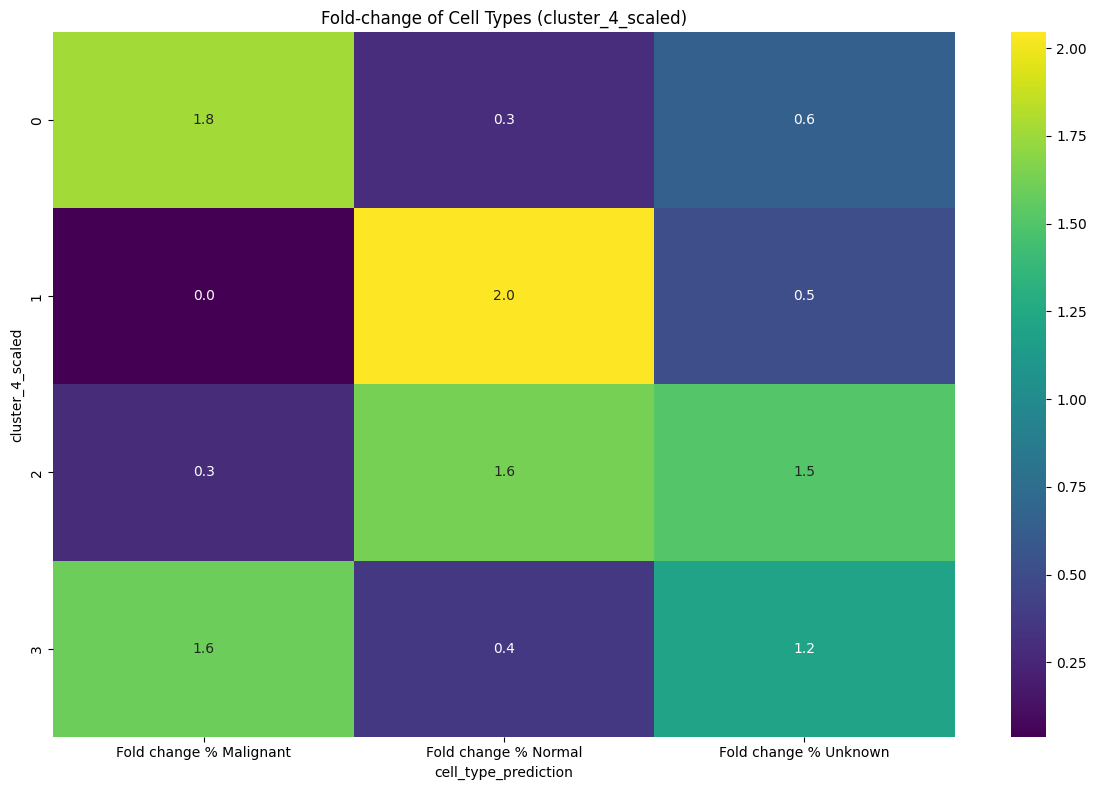

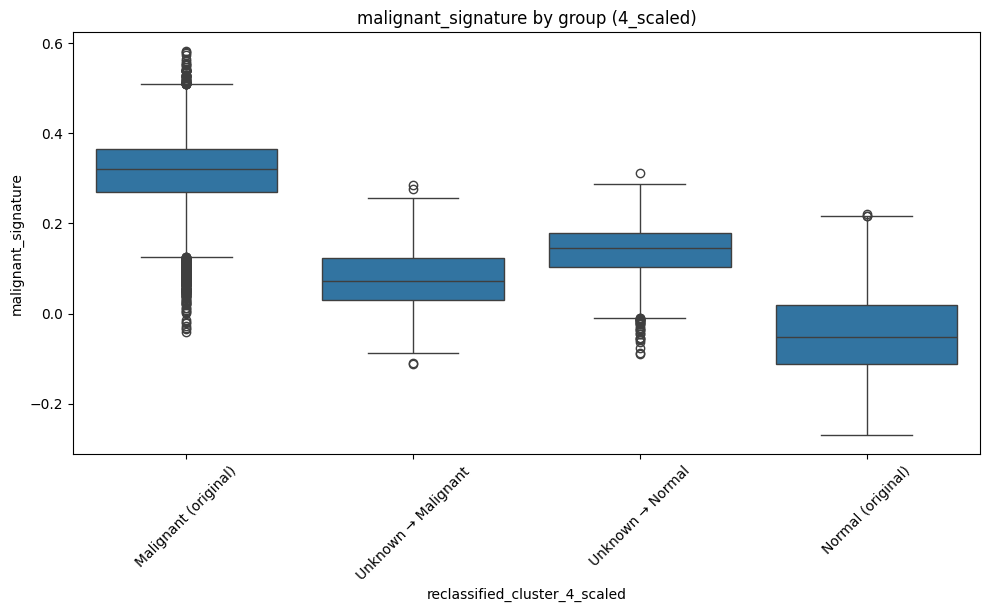

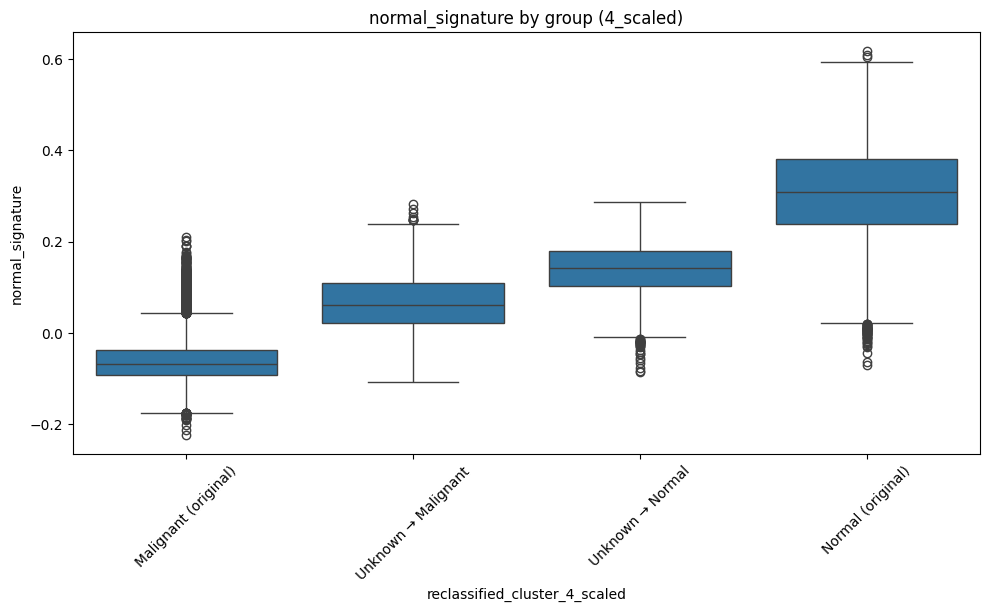

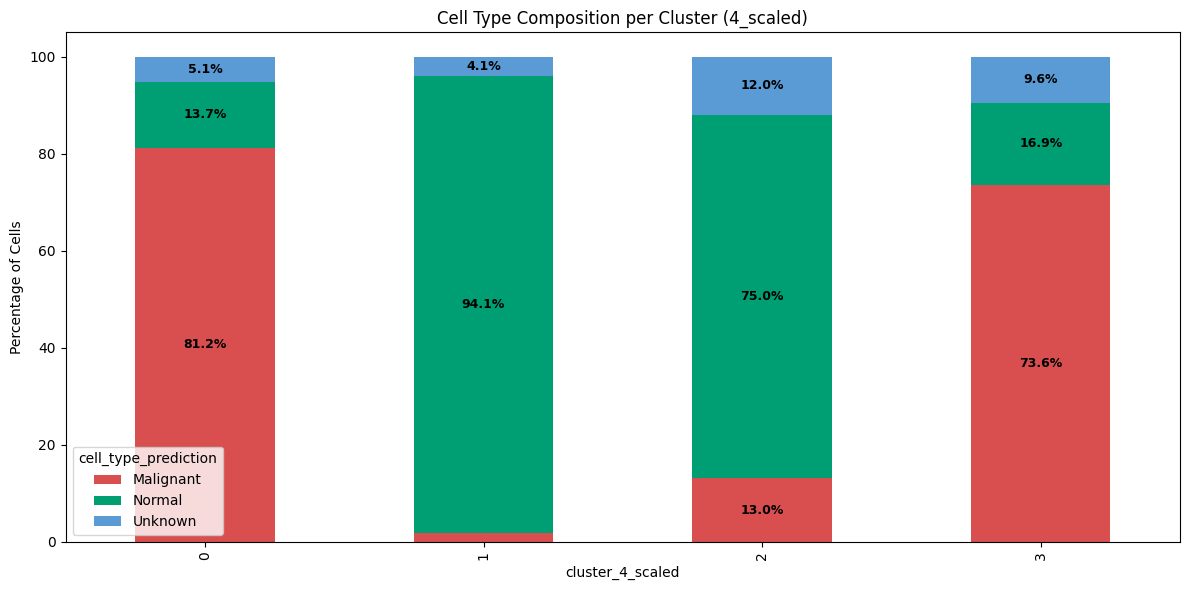

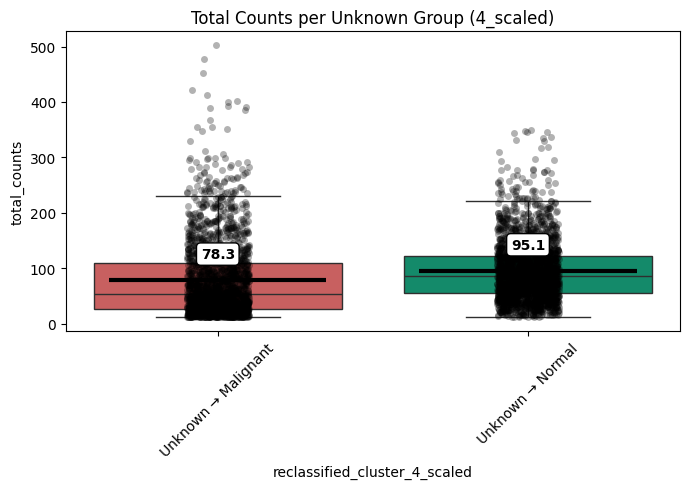

Mann-Whitney U test between 'Unknown → Malignant' and 'Unknown → Normal':
Statistic = 1694247.000, p-value = 5.0482e-53
The difference is statistically significant (p < 0.05).
Pearson correlation (Unknown → Malignant) between total_counts and malignant_signature:
r = 0.395, p-value = 1.6452e-78
Spearman correlation (Unknown → Malignant) between total_counts and malignant_signature:
rho = 0.448, p-value = 4.7060e-103


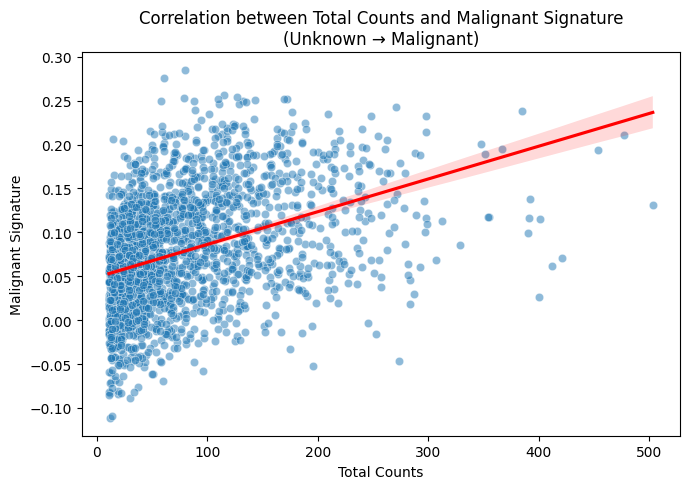

Processing MOLECULAR_SINGLE_FEATURES_DOWN_SCALED with cluster column cluster_2_scaled


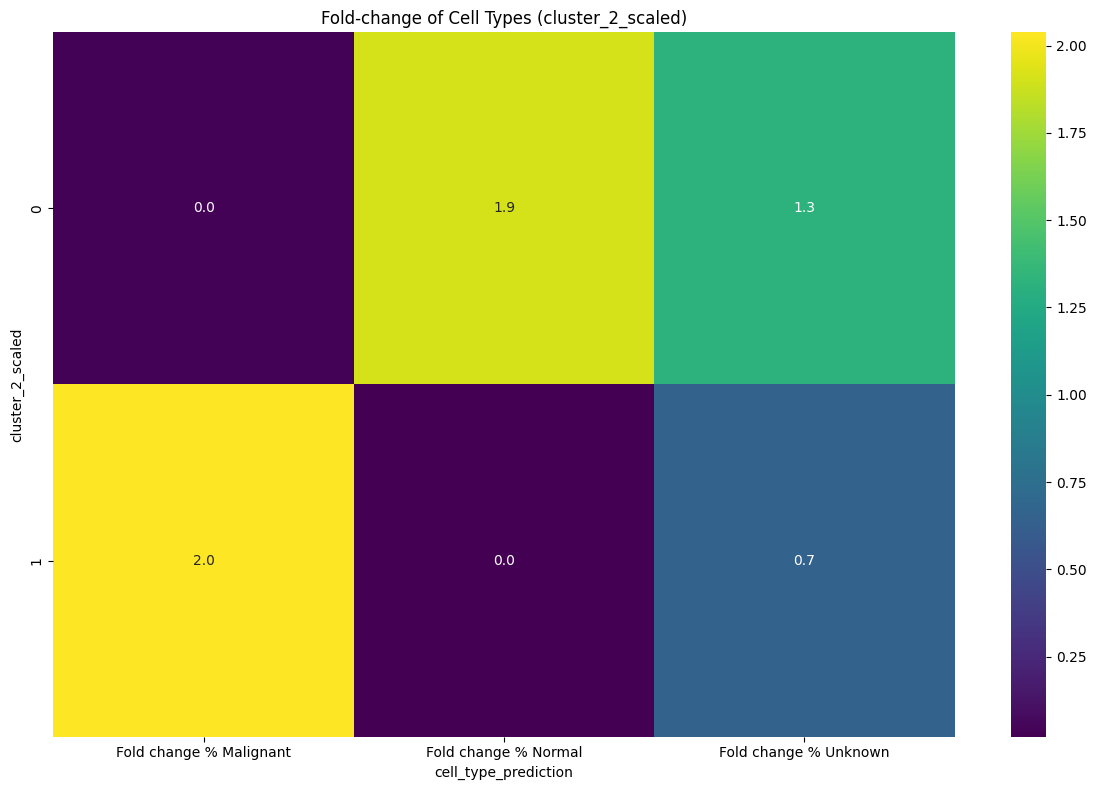

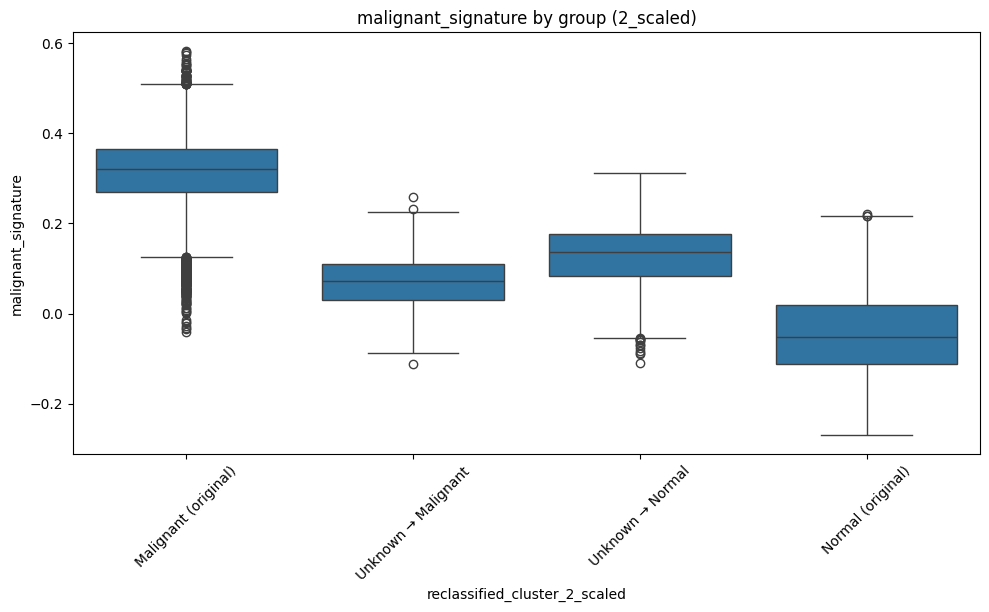

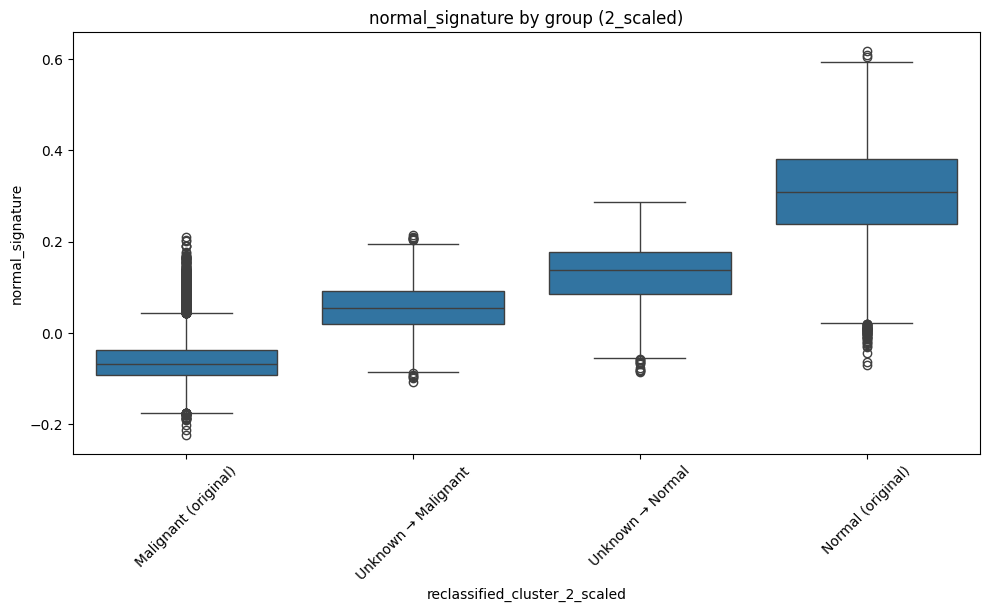

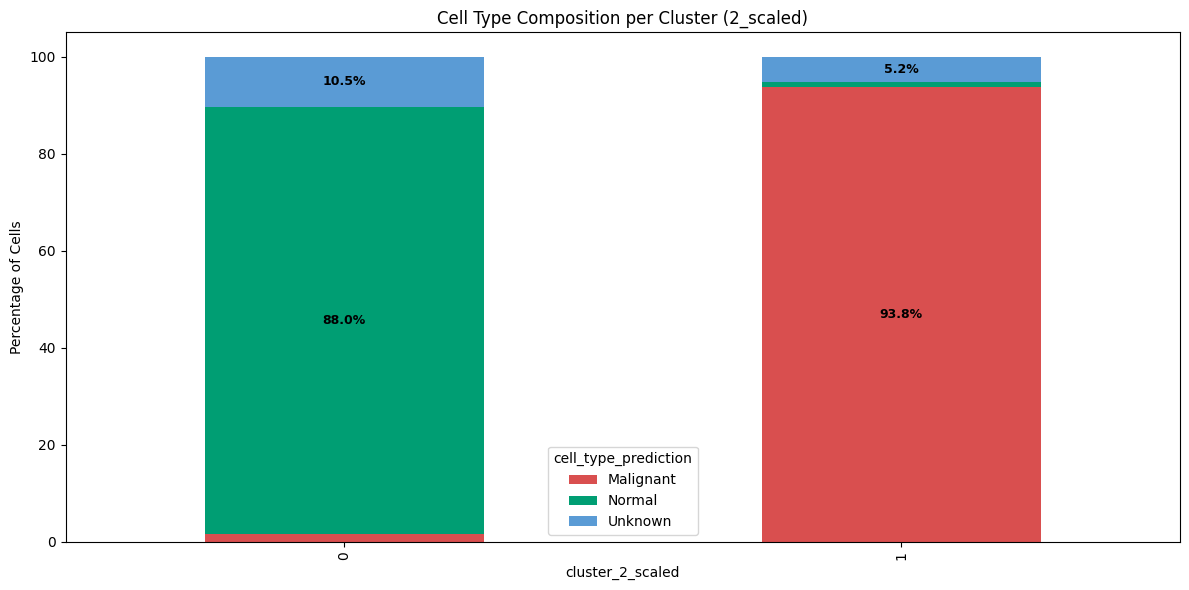

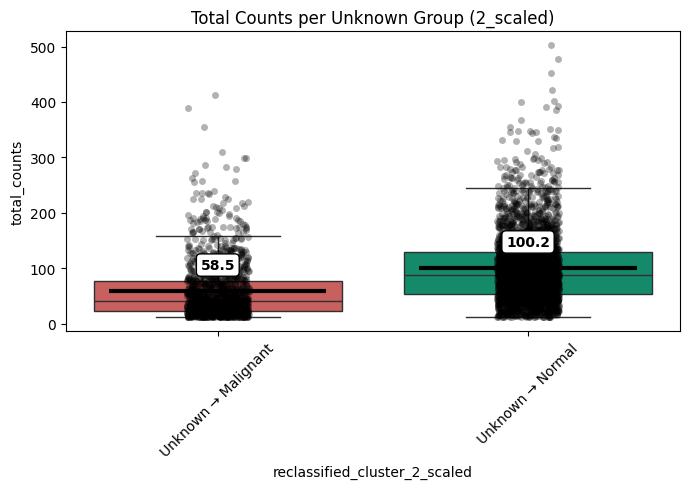

Mann-Whitney U test between 'Unknown → Malignant' and 'Unknown → Normal':
Statistic = 1056607.500, p-value = 2.3421e-139
The difference is statistically significant (p < 0.05).
Pearson correlation (Unknown → Malignant) between total_counts and malignant_signature:
r = 0.352, p-value = 4.1862e-41
Spearman correlation (Unknown → Malignant) between total_counts and malignant_signature:
rho = 0.416, p-value = 2.4099e-58


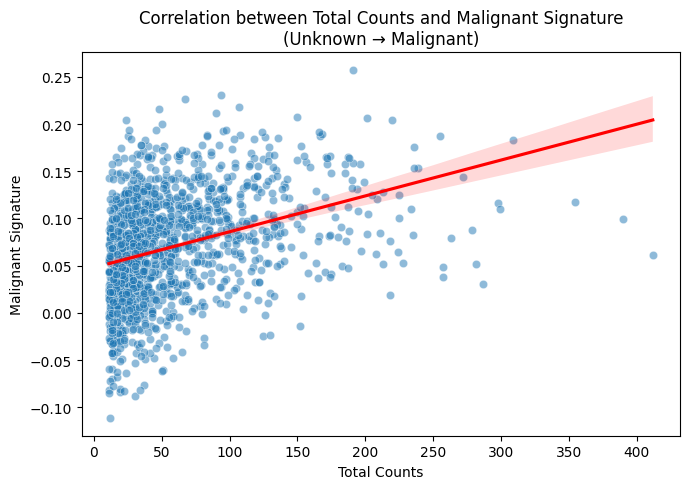

Processing HISTOLOGICAL_SINGLE_FEATURES_DOWN_UNSCALED with cluster column cluster_4_unscaled


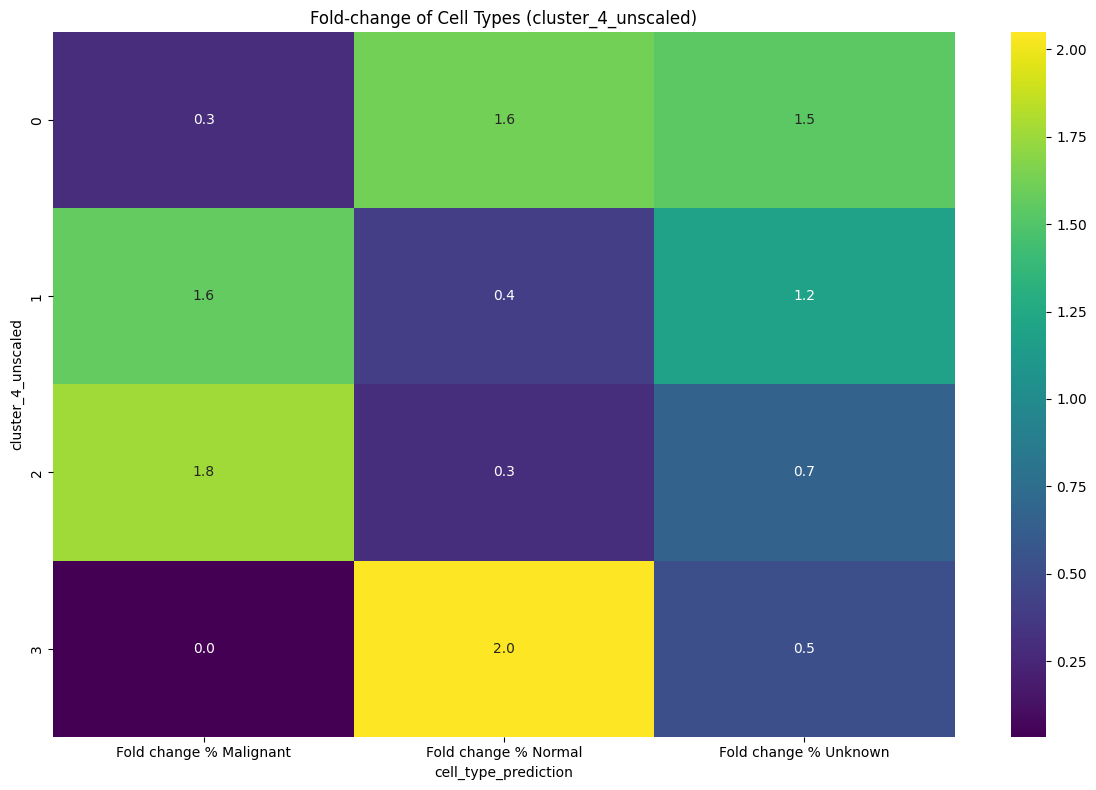

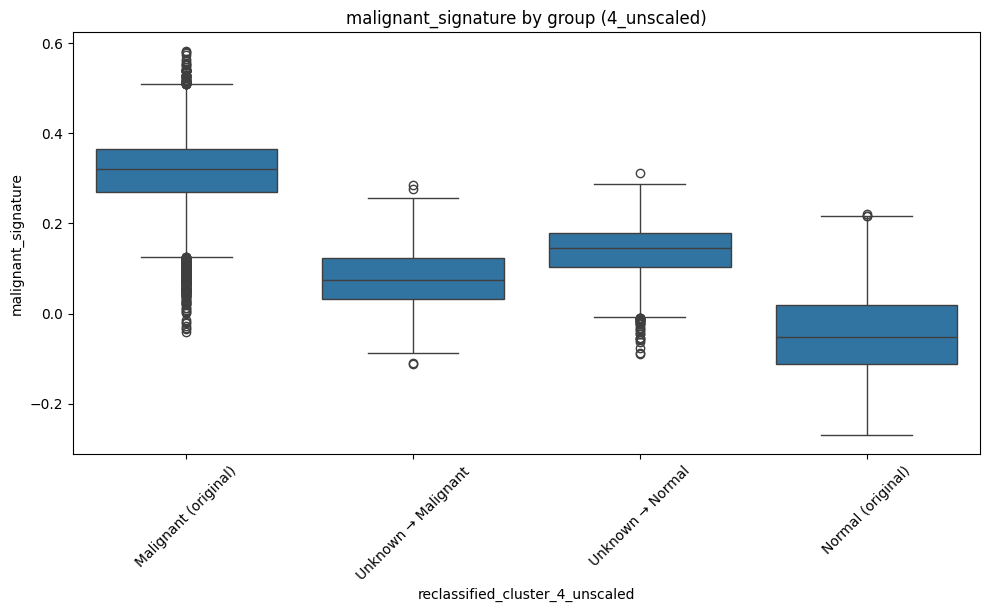

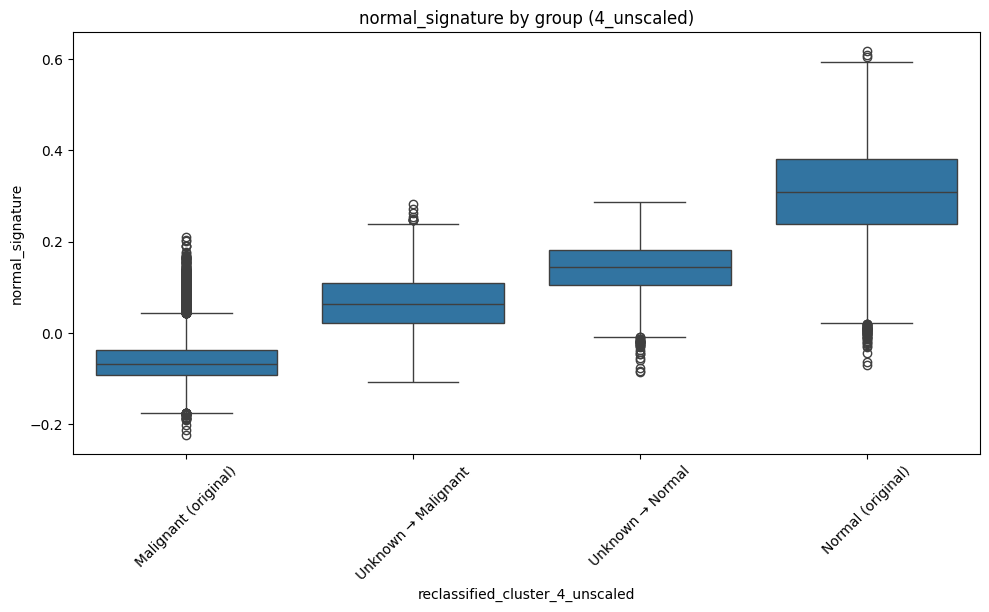

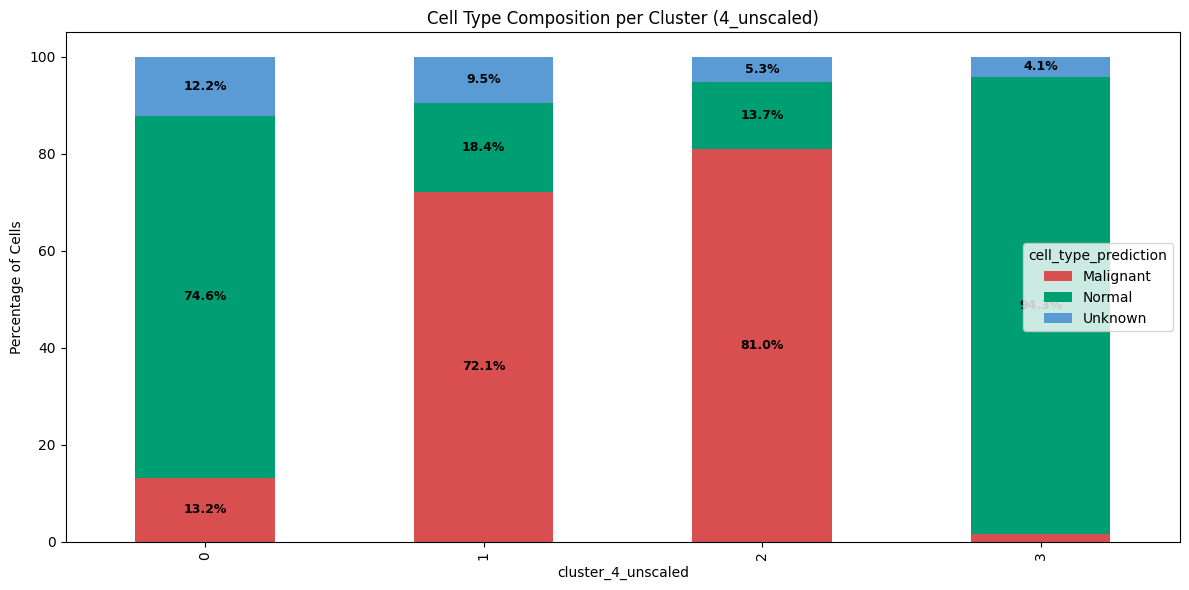

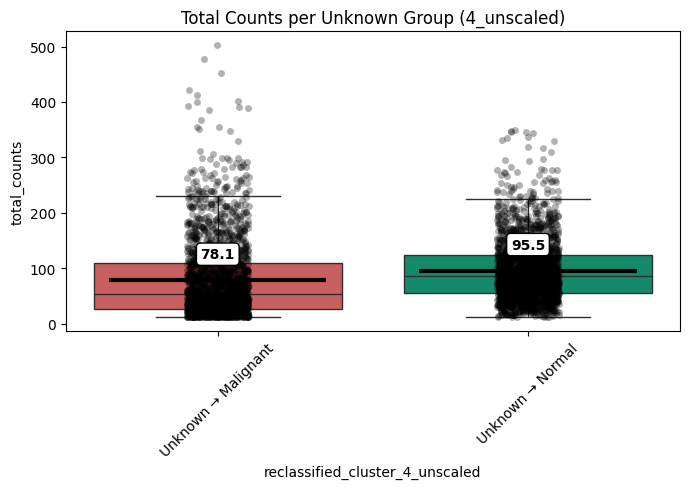

Mann-Whitney U test between 'Unknown → Malignant' and 'Unknown → Normal':
Statistic = 1679614.500, p-value = 9.7503e-56
The difference is statistically significant (p < 0.05).
Pearson correlation (Unknown → Malignant) between total_counts and malignant_signature:
r = 0.395, p-value = 7.1851e-80
Spearman correlation (Unknown → Malignant) between total_counts and malignant_signature:
rho = 0.449, p-value = 4.6132e-105


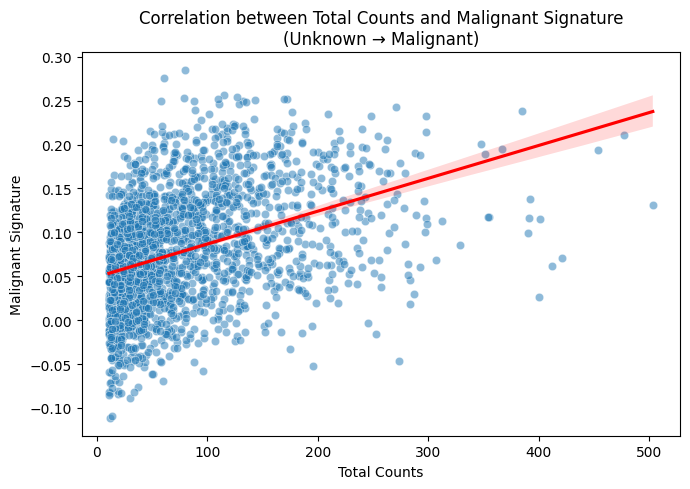

Processing MOLECULAR_SINGLE_FEATURES_DOWN_UNSCALED with cluster column cluster_5_unscaled


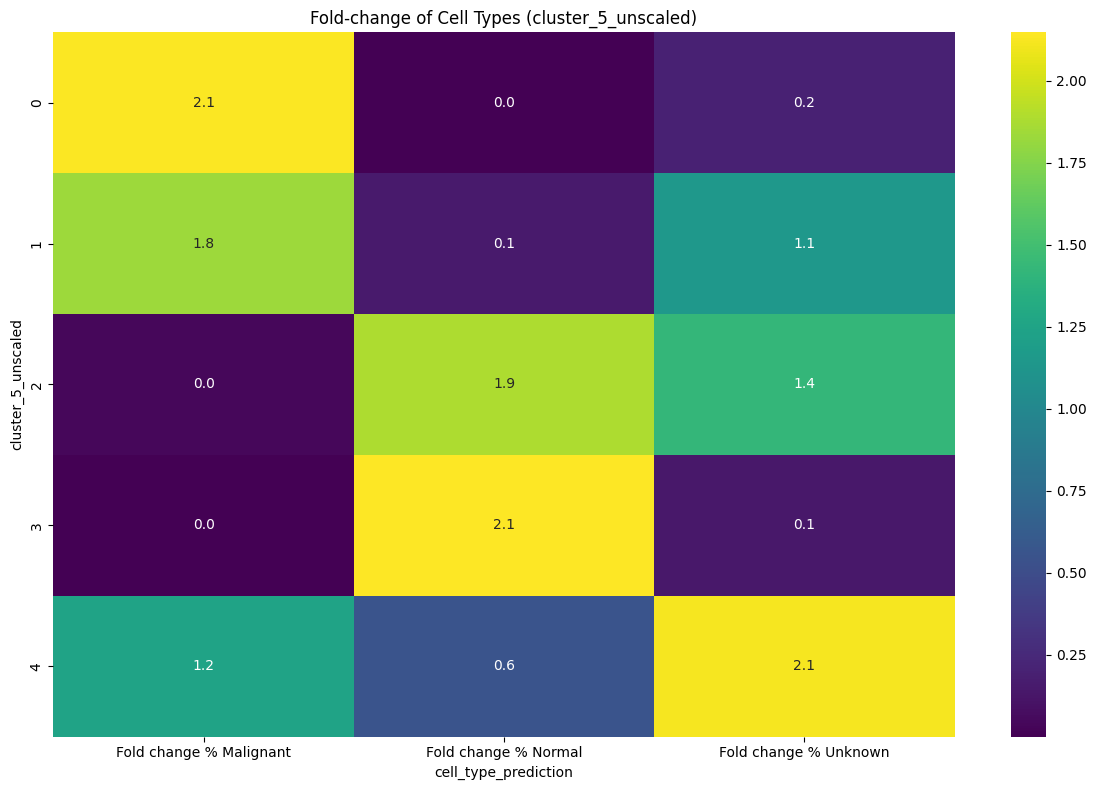

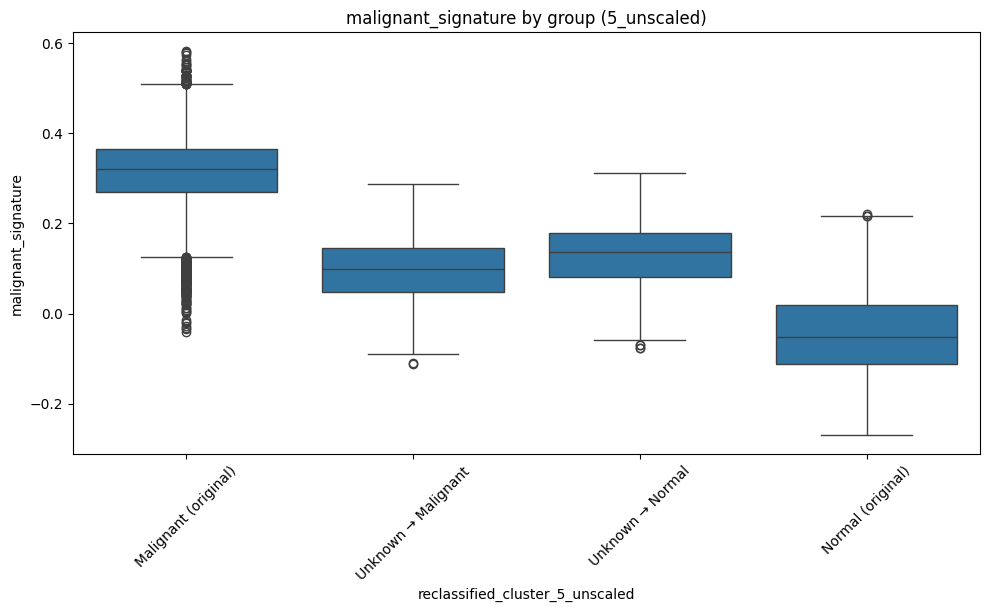

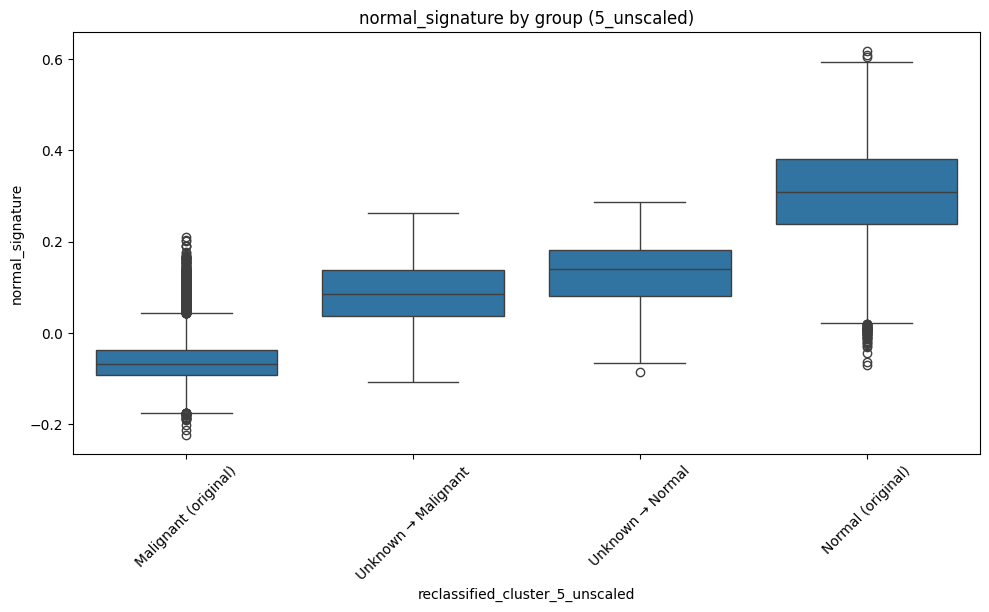

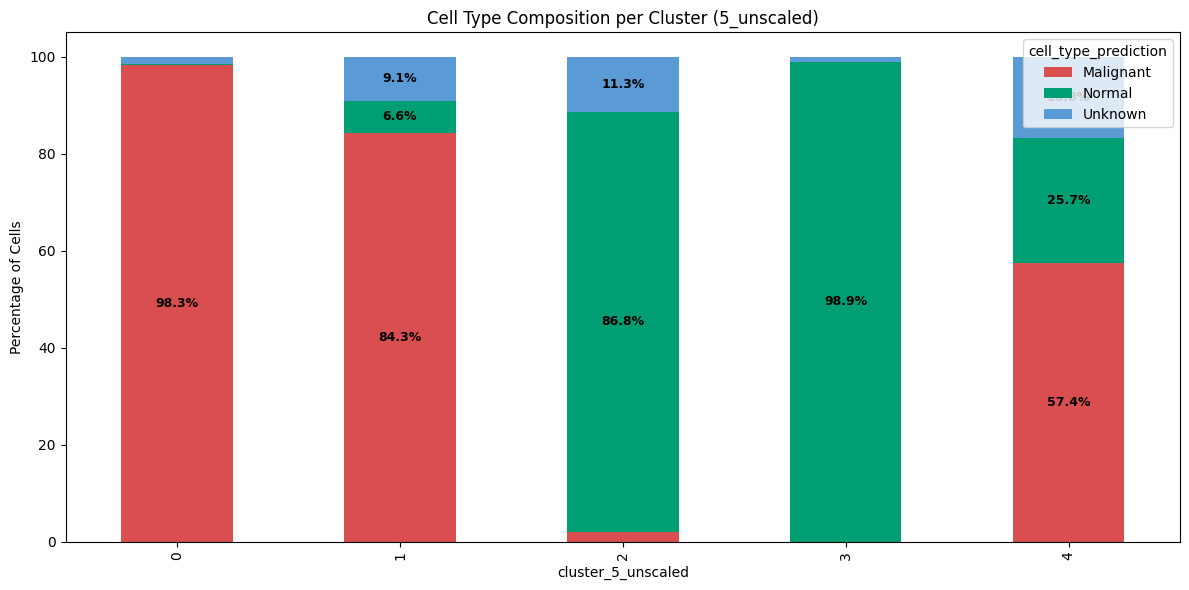

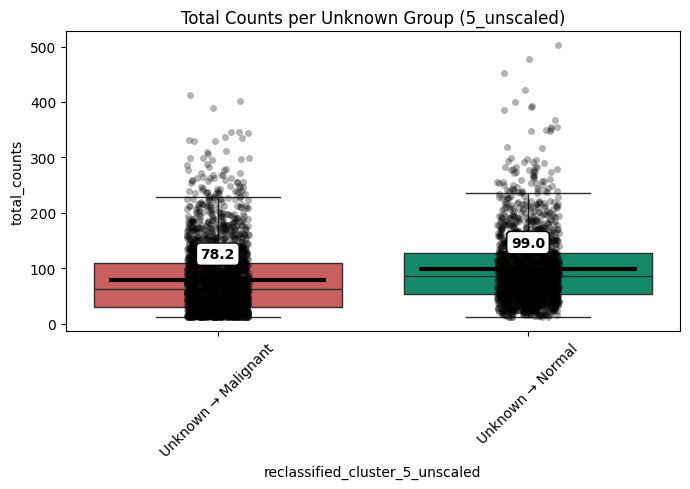

Mann-Whitney U test between 'Unknown → Malignant' and 'Unknown → Normal':
Statistic = 1720061.000, p-value = 5.5939e-42
The difference is statistically significant (p < 0.05).
Pearson correlation (Unknown → Malignant) between total_counts and malignant_signature:
r = 0.458, p-value = 3.6848e-129
Spearman correlation (Unknown → Malignant) between total_counts and malignant_signature:
rho = 0.540, p-value = 6.0512e-188


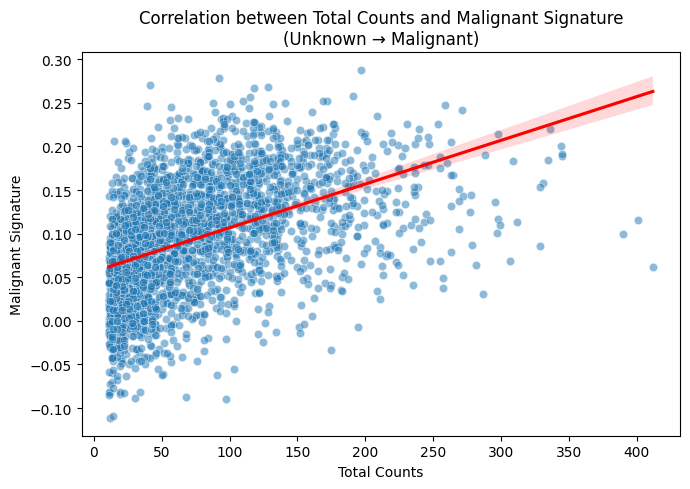

In [18]:
for key, cfg in dataset_configs.items():
    adata = cfg['adata']
    n_comp = cfg['n_comp']

    cluster_col = f"cluster_{n_comp}"

    if cluster_col not in adata.obs.columns:
        print(f"ATTENZIONE: {cluster_col} non trovato in {key}. Colonne disponibili: {adata.obs.columns}")
        continue

    print(f"Processing {key} with cluster column {cluster_col}")

    full_pipeline(
        adata=adata,
        cluster_col=cluster_col,
        malignant_clusters=cfg['malignant_clusters'],
        normal_clusters=cfg['normal_clusters'],
        n_comp=n_comp,           
        output_prefix=key)

## Stratified Sampling for Comparing Unknown→Malignant vs Unknown→Normal
To fairly compare the molecular signatures of the two Unknown groups, stratified sampling is performed based on `total_counts`.

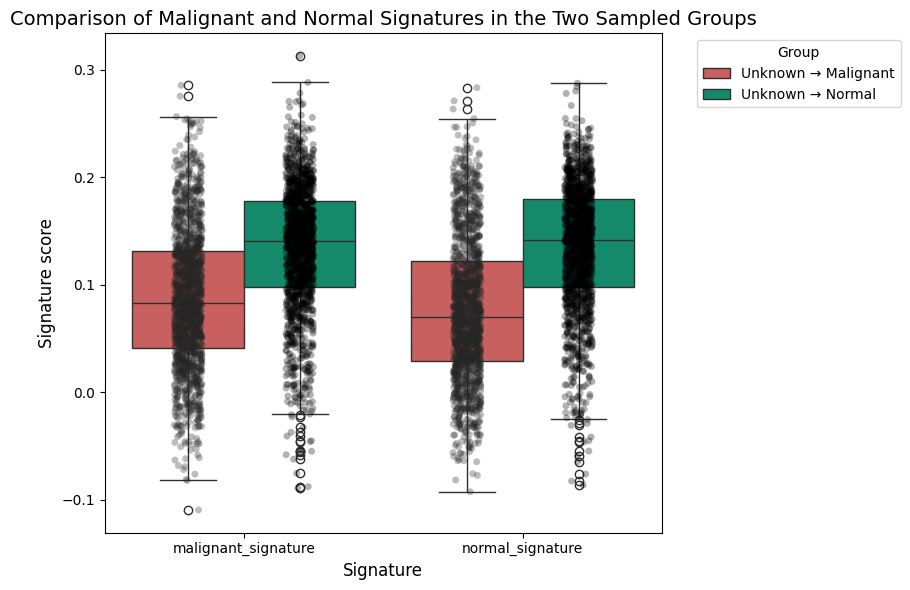


Final proportional distribution by bin - Unknown → Malignant:
count_bin
(10.998000000000001, 12.0]    0.004073
(12.0, 12.2]                  0.000000
(12.2, 13.0]                  0.000679
(13.0, 14.0]                  0.004073
(14.0, 15.0]                  0.004752
                                ...   
(263.167, 275.6]              0.004073
(275.6, 287.9]                0.004073
(287.9, 309.8]                0.002716
(309.8, 350.633]              0.002037
(350.633, 503.0]              0.000000
Name: proportion, Length: 183, dtype: float64

Final proportional distribution by bin - Unknown → Normal:
count_bin
(10.998000000000001, 12.0]    0.004073
(12.0, 12.2]                  0.000000
(12.2, 13.0]                  0.000679
(13.0, 14.0]                  0.004073
(14.0, 15.0]                  0.004752
                                ...   
(263.167, 275.6]              0.004073
(275.6, 287.9]                0.004073
(287.9, 309.8]                0.002716
(309.8, 350.633]              0

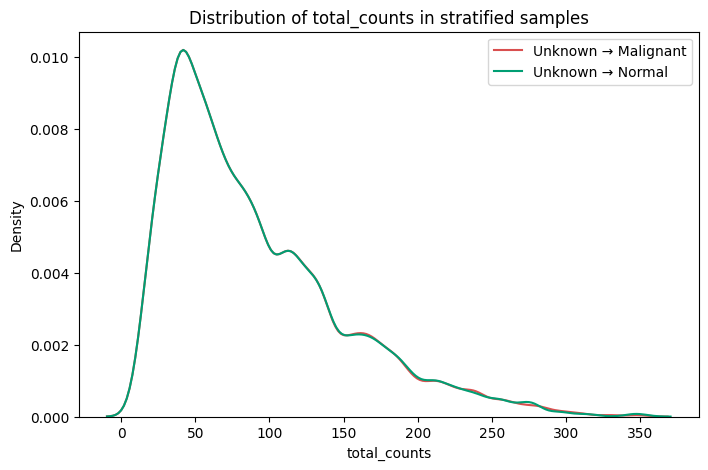

In [14]:
adata = adata_histological_single_features_down
reclassified_col = f'reclassified_cluster_4_scaled'

# Filter cells from the two groups into a single dataframe
df_unknown = adata.obs[adata.obs[reclassified_col].isin(['Unknown → Malignant', 'Unknown → Normal'])].copy()

# Define common bins calculated on the entire dataframe together
n_bins = 300
df_unknown['count_bin'] = pd.qcut(df_unknown['total_counts'], q=n_bins, duplicates='drop')

# Split groups
df_malignant_group = df_unknown[df_unknown[reclassified_col] == 'Unknown → Malignant'].copy()
df_normal_group = df_unknown[df_unknown[reclassified_col] == 'Unknown → Normal'].copy()

def stratified_sample_same_bins_with_print(df_group1, df_group2, n_samples_per_bin=25):
    # Identify bins where both groups have at least one cell
    bins_group1 = set(df_group1['count_bin'].value_counts().index)
    bins_group2 = set(df_group2['count_bin'].value_counts().index)
    common_bins = sorted(list(bins_group1.intersection(bins_group2)))

    samples1 = []
    samples2 = []

    for b in common_bins:
        bin_df1 = df_group1[df_group1['count_bin'] == b]
        bin_df2 = df_group2[df_group2['count_bin'] == b]

        min_count = min(len(bin_df1), len(bin_df2), n_samples_per_bin)
        if min_count == 0:
            continue
        
        samples1.append(bin_df1.sample(n=min_count, random_state=42))
        samples2.append(bin_df2.sample(n=min_count, random_state=42))

    sampled_df1 = pd.concat(samples1).drop(columns='count_bin')
    sampled_df2 = pd.concat(samples2).drop(columns='count_bin')

    return sampled_df1, sampled_df2, common_bins

# Sample cells
sampled_malignant, sampled_normal, common_bins = stratified_sample_same_bins_with_print(
    df_malignant_group, df_normal_group, n_samples_per_bin=25)

# Extract sampled indices
cells_malignant = sampled_malignant.index.tolist()
cells_normal = sampled_normal.index.tolist()

# Prepare dataframe for signature comparison
df_malignant = adata.obs.loc[cells_malignant, ['malignant_signature', 'normal_signature']].copy()
df_malignant['group'] = 'Unknown → Malignant'

df_normal = adata.obs.loc[cells_normal, ['malignant_signature', 'normal_signature']].copy()
df_normal['group'] = 'Unknown → Normal'

df_compare = pd.concat([df_malignant, df_normal])
df_long = df_compare.melt(id_vars='group', var_name='signature', value_name='score')

# Custom color palette
custom_palette = {
    'Unknown → Malignant': '#D94F4F', 
    'Unknown → Normal': '#009E73'}

plt.figure(figsize=(9, 6))
sns.boxplot(data=df_long, x='signature', y='score', hue='group', palette=custom_palette)
sns.stripplot(data=df_long, x='signature', y='score', hue='group', dodge=True, color='black', alpha=0.3, jitter=True, legend=False)

plt.title("Comparison of Malignant and Normal Signatures in the Two Sampled Groups", fontsize=14)
plt.ylabel("Signature score", fontsize=12)
plt.xlabel("Signature", fontsize=12)
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Add total_counts to samples
sampled_malignant = sampled_malignant.assign(total_counts=adata.obs.loc[sampled_malignant.index, 'total_counts'])
sampled_normal = sampled_normal.assign(total_counts=adata.obs.loc[sampled_normal.index, 'total_counts'])

# Recreate bins for samples using original intervals
bin_edges = [common_bins[0].left] + [interval.right for interval in common_bins]

sampled_malignant['count_bin'] = pd.cut(sampled_malignant['total_counts'], bins=bin_edges, include_lowest=True)
sampled_normal['count_bin'] = pd.cut(sampled_normal['total_counts'], bins=bin_edges, include_lowest=True)

# Print proportional distribution per bin
print("\nFinal proportional distribution by bin - Unknown → Malignant:")
print(sampled_malignant['count_bin'].value_counts(normalize=True).sort_index())

print("\nFinal proportional distribution by bin - Unknown → Normal:")
print(sampled_normal['count_bin'].value_counts(normalize=True).sort_index())

# KDE plot for total_counts distributions
plt.figure(figsize=(8,5))
sns.kdeplot(sampled_malignant['total_counts'], label='Unknown → Malignant', bw_adjust=0.5, color=custom_palette['Unknown → Malignant'])
sns.kdeplot(sampled_normal['total_counts'], label='Unknown → Normal', bw_adjust=0.5, color=custom_palette['Unknown → Normal'])
plt.title('Distribution of total_counts in stratified samples')
plt.xlabel('total_counts')
plt.ylabel('Density')
plt.legend()
plt.show()

## Differential Gene Expression (DGE) for Histological Clusters

This section performs differential gene expression analysis across the histological clusters using the Wilcoxon method.  

reclassified_cluster_4_scaled
Malignant (original)    25000
Normal (original)       25000
Unknown → Normal         2233
Unknown → Malignant      2078
Name: count, dtype: int64


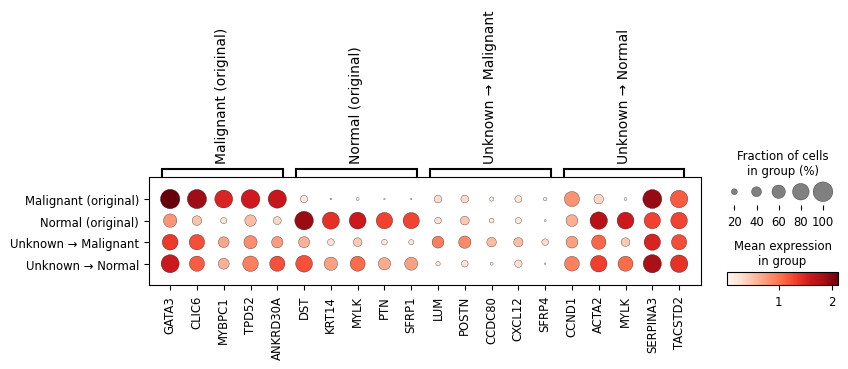

In [15]:
config = dataset_configs['HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED']
adata = config['adata']
cluster_col = 'reclassified_cluster_4_scaled'

# Ensure the column exists and convert it to string
adata.obs[cluster_col] = adata.obs[cluster_col].astype(str)

# Check the clusters present
print(adata.obs[cluster_col].value_counts())

# DGE between histological clusters using Wilcoxon method
sc.tl.rank_genes_groups(adata, groupby=cluster_col, method='wilcoxon')

# Plot the top 5 markers per cluster as a dotplot without dendrogram
sc.pl.rank_genes_groups_dotplot(adata, groupby=cluster_col, n_genes=5, dendrogram=False)

# Save the top markers for each cluster to CSV
res = adata.uns['rank_genes_groups']
groups = res['names'].dtype.names
for group in groups:
    df = pd.DataFrame({
        'gene': res['names'][group],
        'logfoldchange': res['logfoldchanges'][group],
        'pval': res['pvals'][group],
        'pval_adj': res['pvals_adj'][group]})
    df.to_csv(f'results/DGE/markers_cluster_{group}.csv', index=False)

## Differential Gene Expression (DGE) Analysis

In this section, I perform differential gene expression (DGE) analysis to compare the reclassified Unknown cells with their reference groups (Malignant and Normal), as well as between the two Unknown subgroups (Unknown → Malignant vs Unknown → Normal). 

For each contrast, the pipeline:
- Computes DGE using the Wilcoxon test
- Saves the results as CSV files
- Generates Rank Genes plots
- Generates Dotplots for the top genes

This ensures a comprehensive assessment of transcriptional differences across cell subpopulations.


Running DGE: Unknown_to_Malignant_vs_Malignant (n=27078)
Saved: results/DGE/DGE_Unknown_to_Malignant_vs_Malignant.csv


<Figure size 800x600 with 0 Axes>

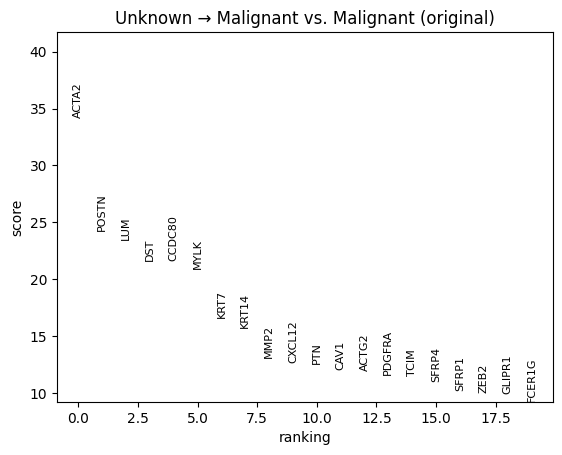

Saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Malignant_vs_Malignant.pdf


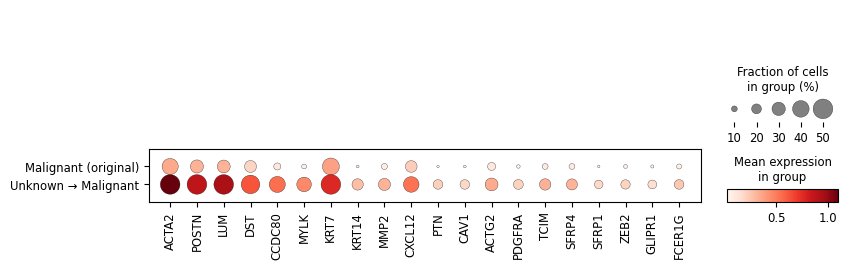

Saved: figures/Dotplot for Unknown_to_Malignant_vs_Malignant

Running DGE: Unknown_to_Normal_vs_Malignant (n=27233)
Saved: results/DGE/DGE_Unknown_to_Normal_vs_Malignant.csv


<Figure size 800x600 with 0 Axes>

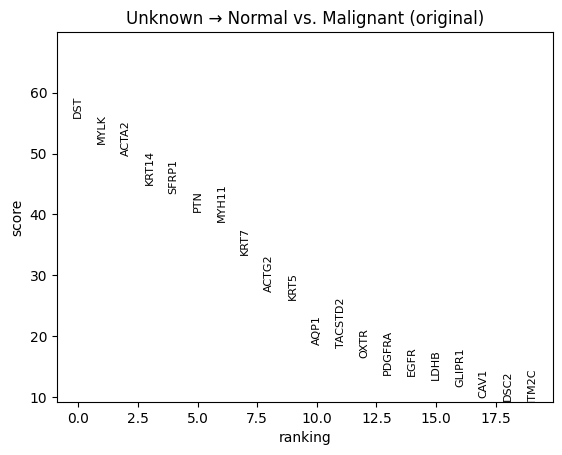

Saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Normal_vs_Malignant.pdf


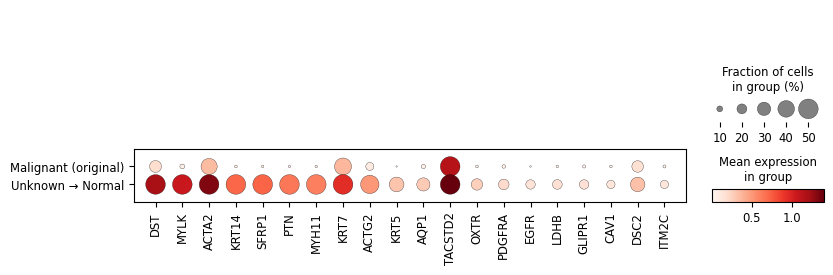

Saved: figures/Dotplot for Unknown_to_Normal_vs_Malignant

Running DGE: Unknown_to_Malignant_vs_Normal (n=27078)
Saved: results/DGE/DGE_Unknown_to_Malignant_vs_Normal.csv


<Figure size 800x600 with 0 Axes>

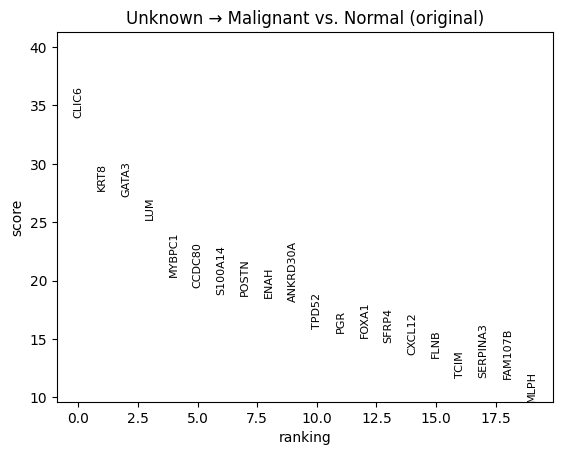

Saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Malignant_vs_Normal.pdf


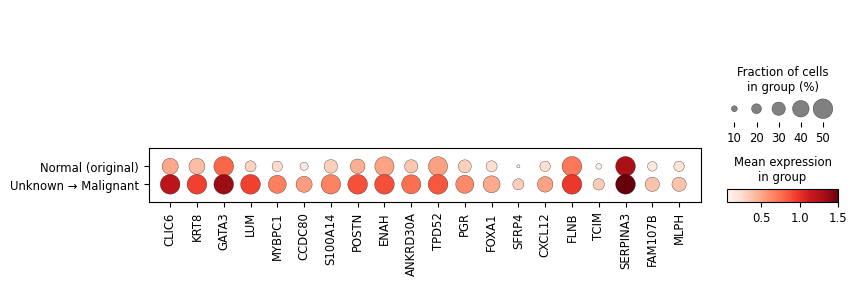

Saved: figures/Dotplot for Unknown_to_Malignant_vs_Normal

Running DGE: Unknown_to_Normal_vs_Normal (n=27233)
Saved: results/DGE/DGE_Unknown_to_Normal_vs_Normal.csv


<Figure size 800x600 with 0 Axes>

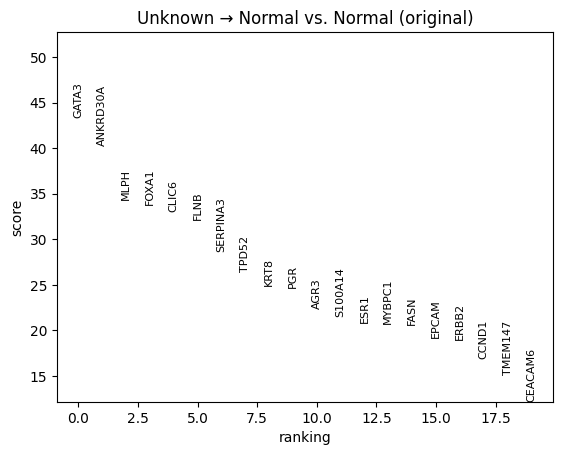

Saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Normal_vs_Normal.pdf


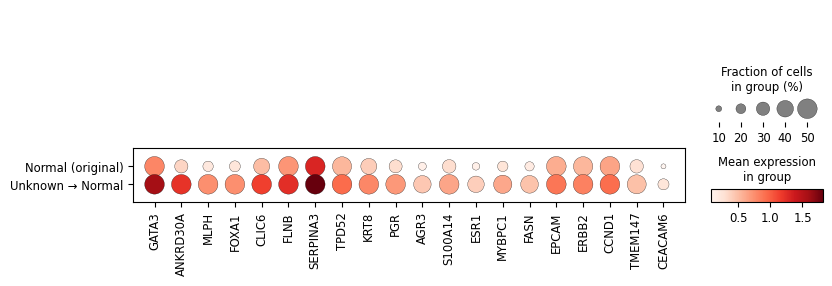

Saved: figures/Dotplot for Unknown_to_Normal_vs_Normal

Running DGE: Unknown_→_Malignant_vs_Unknown_→_Normal (n=4311)
Saved: results/DGE/DGE_Unknown_→_Malignant_vs_Unknown_→_Normal.csv


<Figure size 800x600 with 0 Axes>

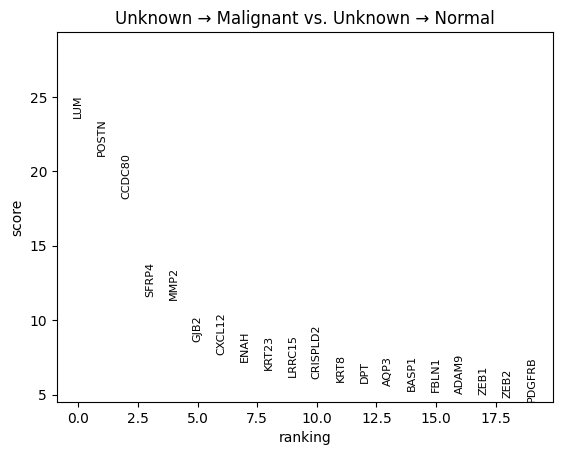

Saved: figures/DGE_rank_genes/RankGenes_Unknown_→_Malignant_vs_Unknown_→_Normal.pdf


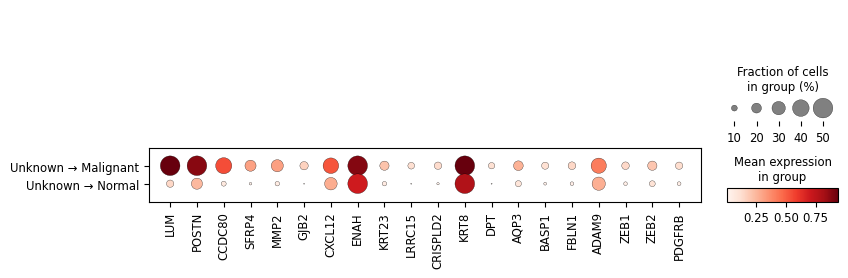

Saved: figures/Dotplot for Unknown_→_Malignant_vs_Unknown_→_Normal


In [16]:
cluster_col = 'reclassified_cluster_4_scaled'

def run_one_dge(sub_adata, contrast_name, ref, group, top_n_genes):
    print(f"\nRunning DGE: {contrast_name} (n={sub_adata.n_obs})")

    # DGE using Wilcoxon
    sc.tl.rank_genes_groups(
        sub_adata, 
        groupby='dge_group', 
        reference=ref, 
        method='wilcoxon')
    res = sub_adata.uns['rank_genes_groups']

    # Identify the group of interest (non-reference)
    other_group = [g for g in res['names'].dtype.names if g != ref][0]

    # Save CSV
    dge_df = pd.DataFrame({
        'gene': res['names'][other_group],
        'logfoldchange': res['logfoldchanges'][other_group],
        'pval': res['pvals'][other_group],
        'pval_adj': res['pvals_adj'][other_group]
    }).sort_values('pval_adj')
    dge_df.to_csv(f"results/DGE/DGE_{contrast_name}.csv", index=False)
    print(f"Saved: results/DGE/DGE_{contrast_name}.csv")

    # Rank genes plot
    plt.figure(figsize=(8,6))
    sc.pl.rank_genes_groups(
        sub_adata, 
        n_genes=top_n_genes, 
        sharey=False, 
        show=True, 
        use_raw=False, 
        title=contrast_name)
    plt.savefig(f"figures/DGE_rank_genes/RankGenes_{contrast_name}.pdf", dpi=300)
    plt.close()
    print(f"Saved: figures/DGE_rank_genes/RankGenes_{contrast_name}.pdf")

    # Dotplot of top genes (real mean values)
    top_genes = pd.Series(res['names'][other_group]).dropna().head(top_n_genes).tolist()
    if top_genes:
        sc.pl.dotplot(
            sub_adata,
            var_names=top_genes,
            groupby='dge_group',
            standard_scale=None,  
            dot_max=0.5,
            color_map='Reds',
            show=True,
            save=f"{contrast_name}.pdf")
        print(f"Saved: figures/Dotplot for {contrast_name}")

def run_dge_and_dotplots(
    adata, 
    reclassified_col, 
    celltype_col, 
    unknown_subgroups, 
    references, 
    top_n_genes=25):

    # --- Part 1: Unknown vs Malignant/Normal ---
    for ref in references:
        for unk_group in unknown_subgroups:
            contrast_name = f"{unk_group.replace(' ', '_').replace('→', 'to')}_vs_{ref}"
            cells_condition = (
                (adata.obs[reclassified_col] == unk_group) |
                (adata.obs[celltype_col] == ref))
            sub_adata = adata[cells_condition].copy()
            sub_adata.obs['dge_group'] = sub_adata.obs[reclassified_col].where(
                sub_adata.obs[reclassified_col] == unk_group,
                f"{ref} (original)")
            run_one_dge(sub_adata, contrast_name, f"{ref} (original)", unk_group, top_n_genes)

    # --- Part 2: Unknown→Malignant vs Unknown→Normal ---
    unk1, unk2 = "Unknown → Malignant", "Unknown → Normal"
    contrast_name = f"{unk1.replace(' ', '_')}_vs_{unk2.replace(' ', '_')}"
    cells_condition = (
        (adata.obs[reclassified_col] == unk1) |
        (adata.obs[reclassified_col] == unk2))
    sub_adata = adata[cells_condition].copy()
    sub_adata.obs['dge_group'] = sub_adata.obs[reclassified_col]
    run_one_dge(sub_adata, contrast_name, unk2, unk1, top_n_genes)

# Main parameters
reclassified_col = cluster_col

celltype_col = 'cell_type_prediction'
unknown_subgroups = ['Unknown → Malignant', 'Unknown → Normal']
references = ['Malignant', 'Normal']

# Run all DGE analyses and dotplots
run_dge_and_dotplots(
    adata,
    reclassified_col,
    celltype_col,
    unknown_subgroups,
    references,
    top_n_genes=20)

## Average Gene Expression in the Target Cluster

This section computes the average gene expression for a specific target cluster (`Unknown → Malignant`) compared to all other cells.  

Steps performed:  
- Select the cells belonging to the target cluster and the rest.  
- Compute mean expression for each gene in the target and other cells.  
- Calculate the difference in expression between target and other cells.  
- Display the top genes with the highest differential expression.  
- Generate a dotplot for selected marker genes.  
- Print the mean expression of selected markers per cluster.  

This helps to highlight genes specifically enriched in the target cluster.

In [17]:
cluster_col = 'reclassified_cluster_4_scaled'
target_cluster = 'Unknown → Malignant'

# Select cells belonging to the target cluster
cells_target = adata.obs[adata.obs[cluster_col] == target_cluster].index
cells_other = adata.obs[adata.obs[cluster_col] != target_cluster].index

# Compute mean gene expression for target and other cells
mean_expr_target = adata[cells_target].X.mean(axis=0).A1  # .A1 converts sparse matrix to 1D array
mean_expr_other = adata[cells_other].X.mean(axis=0).A1

genes = adata.var_names

# Create DataFrame
df_means = pd.DataFrame({
    'gene': genes,
    'mean_expr_target': mean_expr_target,
    'mean_expr_other': mean_expr_other,
    'diff': mean_expr_target - mean_expr_other})

# Sort by decreasing difference
df_means_sorted = df_means.sort_values('diff', ascending=False)

print(df_means_sorted.head(4))

       gene  mean_expr_target  mean_expr_other      diff
159     LUM          0.940044         0.301796  0.638247
201   POSTN          0.875452         0.385857  0.489595
35   CCDC80          0.544045         0.129499  0.414546
76   CXCL12          0.527710         0.232229  0.295481


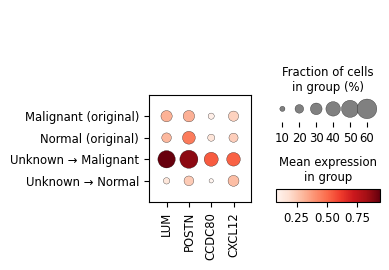

                                    LUM     POSTN    CCDC80    CXCL12
reclassified_cluster_4_scaled                                        
Malignant (original)           0.316959  0.320681  0.107428  0.224537
Normal (original)              0.300128  0.463494  0.156431  0.235525
Unknown → Malignant            0.940044  0.875453  0.544045  0.527710
Unknown → Normal               0.150756  0.246381  0.075067  0.281500


In [18]:
sc.pl.dotplot(
    adata,
    var_names=['LUM', 'POSTN', 'CCDC80', 'CXCL12'],
    groupby=reclassified_col,  
    color_map='Reds',
    show=True)

mean_expr = adata.to_df()[['LUM', 'POSTN', 'CCDC80', 'CXCL12']].join(
    adata.obs[reclassified_col]
).groupby(reclassified_col).mean()

print(mean_expr)

## Final Cell Classification

Aggregation of the reclassified clusters into the final categories: Malignant, Normal, and Unknown.

In [19]:
adata=adata_histological_single_features_down
reclassified_col='reclassified_cluster_4_scaled'

adata.obs['final_labels_scaled'] = adata.obs[reclassified_col].apply(
    lambda x: 'Malignant' if x in ['Malignant (original)', 'Unknown → Malignant'] 
             else 'Normal' if x in ['Normal (original)', 'Unknown → Normal'] 
             else 'Unknown' if x == 'Unknown (unchanged)' 
             else x)

print(adata.obs['final_labels_scaled'].value_counts())

final_labels_scaled
Normal       27233
Malignant    27078
Name: count, dtype: int64


## UMAP Visualization of Features

UMAP embeddings computed for both histological and molecular features, considering both scaled and unscaled versions.

In [12]:
def preprocess_and_umap(adata, rep_name, cluster_col, title):
    sc.pp.neighbors(adata, use_rep=rep_name)
    sc.tl.umap(adata)
    sc.pl.umap(
        adata, 
        color=cluster_col, 
        title=title, 
        palette="tab10", 
        legend_loc="right margin")

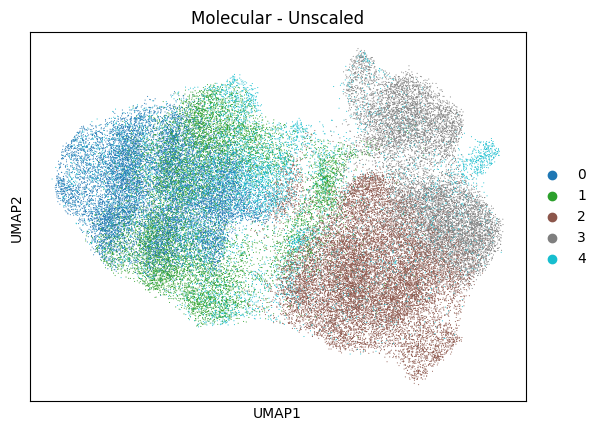

<Figure size 640x480 with 0 Axes>

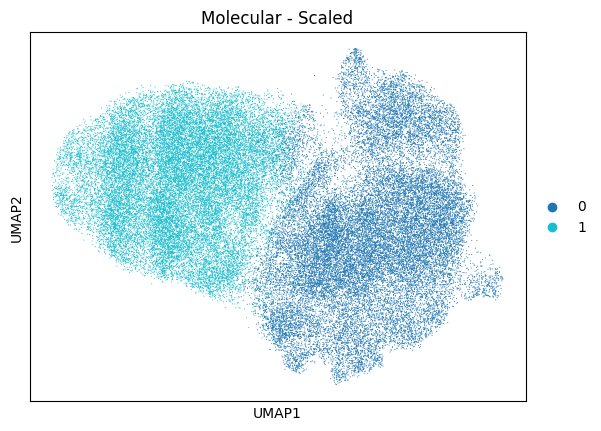

<Figure size 640x480 with 0 Axes>

In [21]:
# Unscaled
preprocess_and_umap(
    adata_molecular_single_features_down,
    rep_name="molecular_single_features",
    cluster_col="cluster_5_unscaled",
    title="Molecular - Unscaled")
plt.savefig("figures/molecular_single_features_cluster_5_unscaled.pdf", dpi=300)

# Scaled
preprocess_and_umap(
    adata_molecular_single_features_down,
    rep_name="molecular_single_features_scaled",
    cluster_col="cluster_2_scaled",
    title="Molecular - Scaled")
plt.savefig("figures/molecular_single_features_scaled_cluster_2_scaled.pdf", dpi=300)

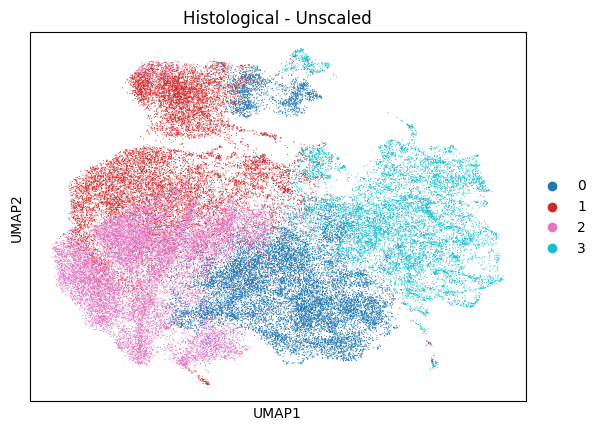

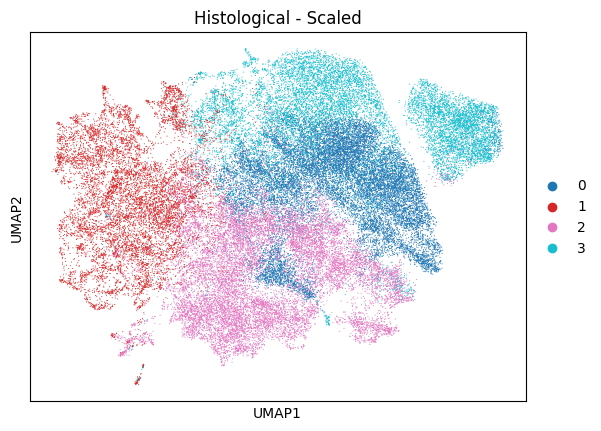

In [26]:
# Unscaled
preprocess_and_umap(
    adata_histological_single_features_down,
    rep_name="histological_single_features",
    cluster_col="cluster_4_unscaled",
    title="Histological - Unscaled")

# Scaled
preprocess_and_umap(
    adata_histological_single_features_down,
    rep_name="histological_single_features_scaled",
    cluster_col="cluster_4_scaled",
    title="Histological - Scaled")

In [13]:
def run_gmm_clustering_on_features(
    adata,
    feature_key: str,
    cluster_key: str = 'GMM_clusters',
    n_components: int = 2,
    random_state: int = 42,
    compute_umap: bool = True):

    # Extract features
    X = adata.obsm[feature_key]

    # Apply GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    clusters = gmm.fit_predict(X)

    # Save clusters in obs
    adata.obs[cluster_key] = clusters.astype(str)  # salva come stringa per compatibilità grafici
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")

    # Compute neighbors + UMAP
    if compute_umap:
        sc.pp.neighbors(adata, use_rep=feature_key)
        sc.tl.umap(adata)

    print(f"GMM clustering with {n_components} clusters saved in adata.obs['{cluster_key}']")

In [14]:
# MOLECULAR SINGLE FEATURES DOWN SCALED
run_gmm_clustering_on_features(
    adata=adata_molecular_single_features_down,
    feature_key='molecular_single_features_scaled',
    cluster_key='GMM_clusters_scaled')

run_gmm_clustering_on_features(
    adata=adata_molecular_single_features_down,
    feature_key='molecular_single_features',
    cluster_key='GMM_clusters_unscaled')

# HISTOLOGICAL SINGLE FEATURES DOWN SCALED
run_gmm_clustering_on_features(
    adata=adata_histological_single_features_down,
    feature_key='histological_single_features_scaled',
    cluster_key='GMM_clusters_scaled')

# HISTOLOGICAL SINGLE FEATURES DOWN 
run_gmm_clustering_on_features(
    adata=adata_histological_single_features_down,
    feature_key='histological_single_features',
    cluster_key='GMM_clusters_unscaled')

GMM clustering with 2 clusters saved in adata.obs['GMM_clusters_scaled']
GMM clustering with 2 clusters saved in adata.obs['GMM_clusters_unscaled']
GMM clustering with 2 clusters saved in adata.obs['GMM_clusters_scaled']
GMM clustering with 2 clusters saved in adata.obs['GMM_clusters_unscaled']


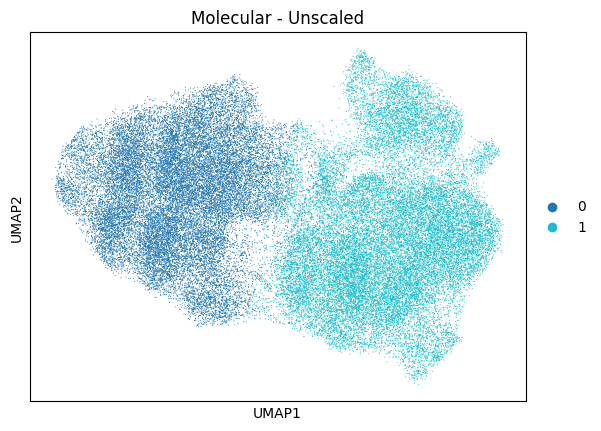

<Figure size 640x480 with 0 Axes>

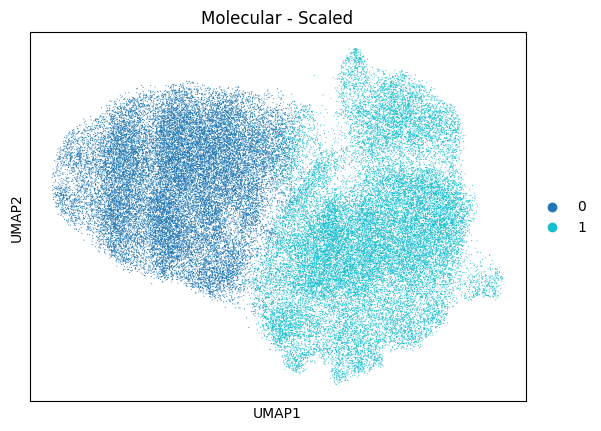

<Figure size 640x480 with 0 Axes>

In [15]:
# Unscaled
preprocess_and_umap(
    adata_molecular_single_features_down,
    rep_name="molecular_single_features",
    cluster_col="GMM_clusters_unscaled",
    title="Molecular - Unscaled")
plt.savefig("figures/molecular_single_features_cluster_gmm.pdf", dpi=300)

# Scaled
preprocess_and_umap(
    adata_molecular_single_features_down,
    rep_name="molecular_single_features_scaled",
    cluster_col="GMM_clusters_scaled",
    title="Molecular - Scaled")
plt.savefig("figures/molecular_single_features_scaled_cluster_gmm.pdf", dpi=300)

GMM_clusters_scaled      0      1
cluster_2_scaled                 
0                        4  28134
1                    26173      0


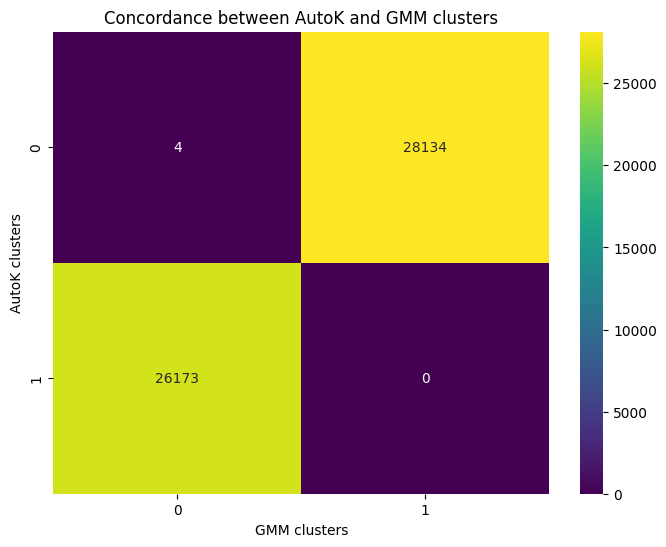

Adjusted Rand Index (ARI): 1.000
Normalized Mutual Information (NMI): 0.999


In [55]:
# Cluster columns
autok_cluster_col = "cluster_2_scaled"  # clusters obtained with AutoK
gmm_cluster_col = "GMM_clusters_scaled"  # assuming you renamed GMM clusters for n_comp

# Contingency table
ct = pd.crosstab(
    adata_molecular_single_features_down.obs[autok_cluster_col],
    adata_molecular_single_features_down.obs[gmm_cluster_col])
print(ct)

# Heatmap to visualize the correspondence
plt.figure(figsize=(8,6))
sns.heatmap(ct, annot=True, fmt="d", cmap="viridis")
plt.title("Concordance between AutoK and GMM clusters")
plt.ylabel("AutoK clusters")
plt.xlabel("GMM clusters")
plt.show()

# Concordance metrics
ari = adjusted_rand_score(
    adata_molecular_single_features_down.obs[autok_cluster_col],
    adata_molecular_single_features_down.obs[gmm_cluster_col])
nmi = normalized_mutual_info_score(
    adata_molecular_single_features_down.obs[autok_cluster_col],
    adata_molecular_single_features_down.obs[gmm_cluster_col])

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

## Comparison of AutoK Clusters vs Cell Type Predictions

Side-by-side UMAP visualization:  
- Left: clusters identified by AutoK  
- Right: original cell type predictions

In [27]:
def plot_umap_autok_vs_celltype(
    adata,
    cluster_key: str = None,
    celltype_palette: dict = {'Normal': '#009E73', 'Malignant': '#D94F4F', 'Unknown': '#4682B4'},
    title_left: str = 'AutoK Clustering',
    title_right: str = 'Cell Type Prediction',
    figsize: tuple = (12, 5),
    save_path: str = None):
    """
    Displays UMAP plots side by side comparing AutoK clusters and cell type predictions.
    The cluster palette is dynamic based on the number of clusters present (2 or 4).
    """

    # --- Dynamic selection of the cluster column ---
    if cluster_key is None:
        if 'cluster_4_scaled' in adata.obs.columns:
            cluster_key = 'cluster_4_scaled'
        elif 'cluster_2_scaled' in adata.obs.columns:
            cluster_key = 'cluster_2_scaled'
        else:
            raise ValueError("No cluster column found in adata.obs")

    # --- Create dynamic palette for clusters ---
    cluster_categories = pd.unique(adata.obs[cluster_key])
    default_colors = ['#009E73', '#D94F4F', 'blue', 'black', 'orange', 'purple']
    cluster_palette = [default_colors[i % len(default_colors)] for i in range(len(cluster_categories))]

    # --- Create figure ---
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # AutoK Clustering
    sc.pl.umap(
        adata,
        color=cluster_key,
        palette=cluster_palette,
        title=title_left,
        ax=axes[0],
        show=False)

    # Cell Type Prediction
    sc.pl.umap(
        adata,
        color='cell_type_prediction',
        palette=celltype_palette,
        title=title_right,
        ax=axes[1],
        show=False)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

## Analysis of AutoK Clusters in Unknown Cells

- Visualize two UMAPs side by side:  
  - Left: AutoK clusters with Unknown cells highlighted  
  - Right: only Unknown cells shown in red  
- Count how many Unknown cells are classified as Malignant or Normal  
- Display results with a bar plot showing the classification of Unknown cells by AutoK clusters

In [28]:
def plot_autok_vs_unknown_highlight(
    adata,
    title_left: str = 'AutoK clustering of Unknown cells (highlighted)',
    title_right: str = 'Cell Type Prediction (highlight Unknown)',
    save_path: str = None):
    
    # --- Dynamic selection of the cluster column ---
    if 'cluster_4_scaled' in adata.obs.columns:
        cluster_key = 'cluster_4_scaled'
    elif 'cluster_2_scaled' in adata.obs.columns:
        cluster_key = 'cluster_2_scaled'
    else:
        raise ValueError("No cluster column found in adata.obs")

    # --- Dynamic palette based on the number of clusters ---
    cluster_categories = pd.unique(adata.obs[cluster_key])
    n_clusters = len(cluster_categories)
    if n_clusters == 2:
        cluster_palette = {0: '#009E73', 1: '#D94F4F'}
    elif n_clusters == 4:
        cluster_palette = {0: '#D94F4F', 1: '#009E73', 2: 'blue', 3: 'black'}
    else:
        import matplotlib.cm as cm
        colors = cm.tab10.colors
        cluster_palette = {cat: colors[i % 10] for i, cat in enumerate(cluster_categories)}

    # --- Masks for Known and Unknown cells ---
    mask_known = adata.obs['cell_type_prediction'].isin(['Normal', 'Malignant'])
    mask_unknown = adata.obs['cell_type_prediction'] == 'Unknown'

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Left plot: AutoK clustering with Unknown cells highlighted ---
    sc.pl.umap(
        adata[mask_known],
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray'},
        size=10,
        alpha=0.3,
        ax=axes[0],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color=cluster_key,
        palette=cluster_palette,
        size=10,
        alpha=0.6,
        ax=axes[0],
        show=False,
        legend_loc='right')
    axes[0].set_title(title_left)

    # --- Right plot: highlight only Unknown cells ---
    sc.pl.umap(
        adata,
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray', 'Unknown': 'lightgray'},
        size=10,
        alpha=0.5,
        ax=axes[1],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color='cell_type_prediction',
        palette={'Unknown': 'blue'},
        size=10,
        alpha=0.6,
        ax=axes[1],
        show=False)
    axes[1].set_title(title_right)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

In [29]:
def plot_autok_classification_of_unknowns(
    adata,
    cell_type_col: str = 'cell_type_prediction',
    unknown_label: str = 'Unknown',
    cluster_label_map: dict = None,
    new_col: str = 'cell_type_reclassified',
    title: str = 'AutoK Classification of Unknown Cell Types',
    save_path: str = None):
    
    # --- Dynamic selection of the cluster column ---
    if 'cluster_4_scaled' in adata.obs.columns:
        cluster_col = 'cluster_4_scaled'
    elif 'cluster_2_scaled' in adata.obs.columns:
        cluster_col = 'cluster_2_scaled'
    else:
        raise ValueError("No cluster column found in adata.obs")

    # --- Select Unknown cells ---
    unknown_cells = adata[adata.obs[cell_type_col] == unknown_label]
    cluster_data = unknown_cells.obs[cluster_col].copy()

    # --- Apply cluster mapping ---
    if cluster_label_map is not None:
        cluster_data_mapped = cluster_data.map(cluster_label_map)
    else:
        cluster_data_mapped = cluster_data

    # --- Save in a new column ---
    adata.obs.loc[unknown_cells.obs_names, new_col] = cluster_data_mapped
    # Also copy known cells
    known_cells = adata[adata.obs[cell_type_col] != unknown_label]
    adata.obs.loc[known_cells.obs_names, new_col] = known_cells.obs[cell_type_col]

    # --- Prepare dataframe for plotting ---
    df_plot = pd.DataFrame({new_col: adata.obs[new_col]})
    categories = df_plot[new_col].unique()
    
    # --- Dynamic color palette ---
    default_colors = ['#D94F4F', '#009E73', 'blue', 'black', 'orange', 'purple']
    palette_dict = {cat: default_colors[i % len(default_colors)] for i, cat in enumerate(categories)}

    # --- Plot ---
    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=df_plot, x=new_col, order=categories, palette=palette_dict)
    plt.ylabel('Number of Cells')
    plt.title(title)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 1, int(height), ha="center", fontsize=10)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

## Reclassifies Unknown cells based on clusters

The function automatically selects the cluster column from 'cluster_2_scaled' or 'cluster_4_scaled'.

In [32]:
def plot_and_save_reclassified_unknowns(
    adata,
    cell_type_col: str = 'cell_type_prediction',
    unknown_label: str = 'Unknown',
    cluster_label_map: dict = None,
    new_col: str = 'cell_type_reclassified',
    title: str = 'AutoK Classification of Unknown Cell Types',
    save_path: str = None):

    # --- Dynamic selection of the cluster column ---
    if 'cluster_4_scaled' in adata.obs.columns:
        cluster_col = 'cluster_4_scaled'
    elif 'cluster_2_scaled' in adata.obs.columns:
        cluster_col = 'cluster_2_scaled'
    else:
        raise ValueError("No cluster column found in adata.obs")

    # --- Copy the original column ---
    adata.obs[new_col] = adata.obs[cell_type_col].copy()

    # --- Select Unknown cells ---
    unknown_cells = adata[adata.obs[cell_type_col] == unknown_label]
    cluster_data = unknown_cells.obs[cluster_col].copy()

    try:
        cluster_data = cluster_data.astype(int)
    except (ValueError, TypeError):
        pass

    # --- Apply the cluster mapping ---
    if cluster_label_map is not None:
        cluster_data_mapped = cluster_data.map(cluster_label_map)
    else:
        cluster_data_mapped = cluster_data

    # --- Save the reclassified cells ---
    adata.obs.loc[unknown_cells.obs_names, new_col] = cluster_data_mapped

    # --- Prepare dataframe for plotting ---
    df_plot = pd.DataFrame({new_col: cluster_data_mapped})
    categories = df_plot[new_col].unique()

    # --- Define custom colors ---
    custom_palette = {
        'Malignant': '#D94F4F',  # rosso
        'Normal': '#009E73',     # verde
        'Unknown': 'gray'}

    for cat in categories:
        if cat not in custom_palette:
            custom_palette[cat] = 'gray'

    # --- Plot ---
    plt.figure(figsize=(5, 3))  # più piccolo
    ax = sns.countplot(
        data=df_plot,
        x=new_col,
        order=categories,
        palette=[custom_palette[c] for c in categories]
    )
    plt.ylabel('Number of Unknown Cells')
    plt.title(title)

    # --- Add count labels on top of bars ---
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.5,
                int(height), ha="center", fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

Cell Type     Malignant  Normal  Unknown
ClusterAutoK                            
0                   444   24750     2944
1                 24556     250     1367


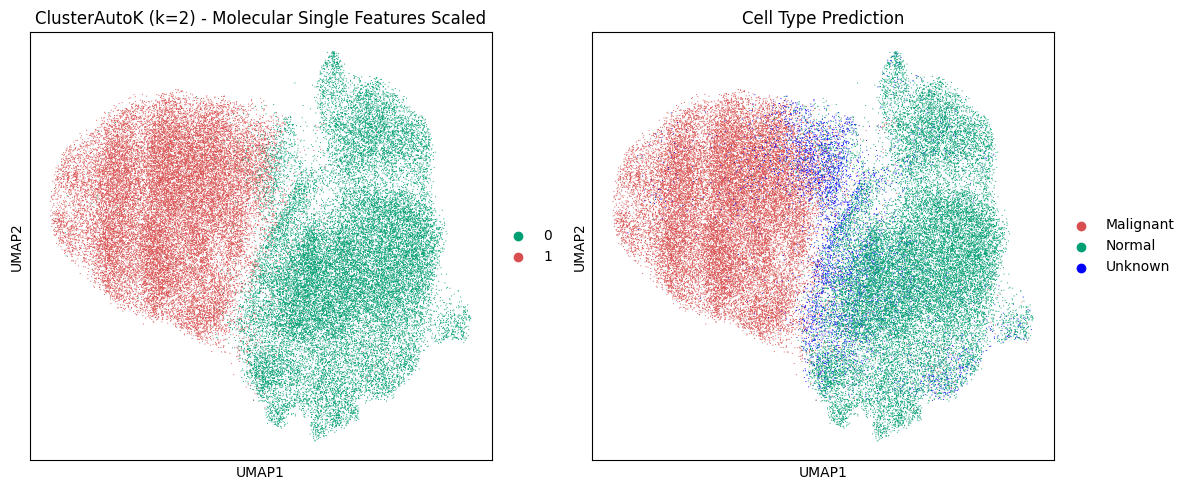

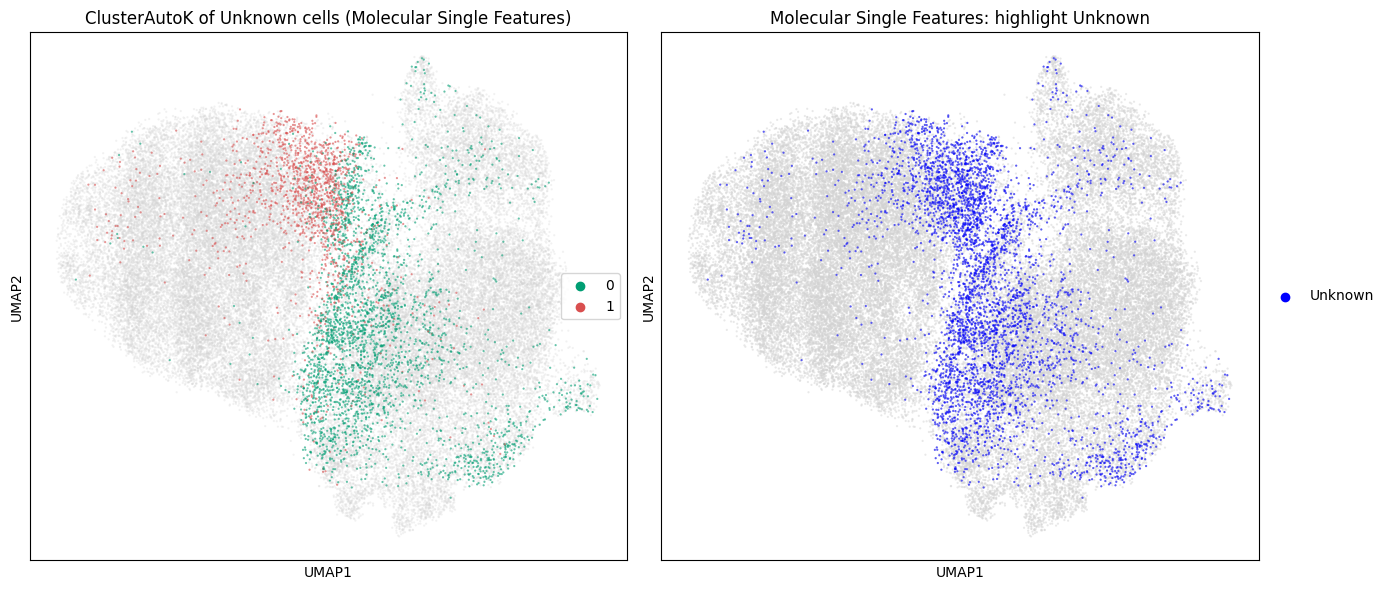

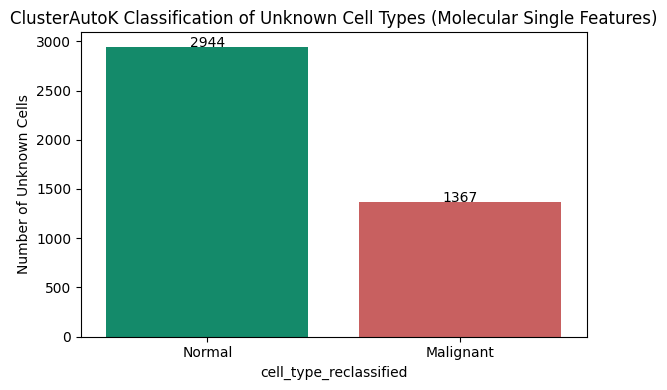

In [24]:
# Cluster counts
adata_molecular_single_features_down.obs["cluster_2_scaled"].value_counts()

# Crosstab with custom labels
print(pd.crosstab(
    adata_molecular_single_features_down.obs["cluster_2_scaled"],
    adata_molecular_single_features_down.obs["cell_type_prediction"],
    rownames=['ClusterAutoK'],        
    colnames=['Cell Type']))


# --- UMAP: AutoK vs Cell Type Prediction ---
plot_umap_autok_vs_celltype(
    adata=adata_molecular_single_features_down,
    cluster_key='cluster_2_scaled',  # Can be automatic if preferred
    celltype_palette={'Normal': '#009E73', 'Malignant': '#D94F4F', 'Unknown': 'blue'},
    title_left='ClusterAutoK (k=2) - Molecular Single Features Scaled',
    title_right='Cell Type Prediction',
    save_path='figures/umap_autok_vs_celltype_molecular_single_features_down_scaled.pdf')

# --- UMAP highlighting only Unknown cells ---
plot_autok_vs_unknown_highlight(
    adata=adata_molecular_single_features_down,
    title_left='ClusterAutoK of Unknown cells (Molecular Single Features)',
    title_right='Molecular Single Features: highlight Unknown',
    save_path='figures/umap_molecular_single_features_down_scaled_autok_vs_unknown.pdf')

# --- Reclassification of Unknown cells and countplot ---
plot_and_save_reclassified_unknowns(
    adata=adata_molecular_single_features_down,
    cell_type_col='cell_type_prediction',
    unknown_label='Unknown',
    cluster_label_map={0: 'Normal', 1: 'Malignant'},
    title='ClusterAutoK Classification of Unknown Cell Types (Molecular Single Features)',
    save_path='figures/barplot_autok_molecular_single_features_down_scaled_unknowns.pdf')

Cell Type     Malignant  Normal  Unknown
ClusterAutoK                            
0                 13332    2243      845
1                   170    9050      393
2                  2003   11529     1840
3                  9495    2178     1233


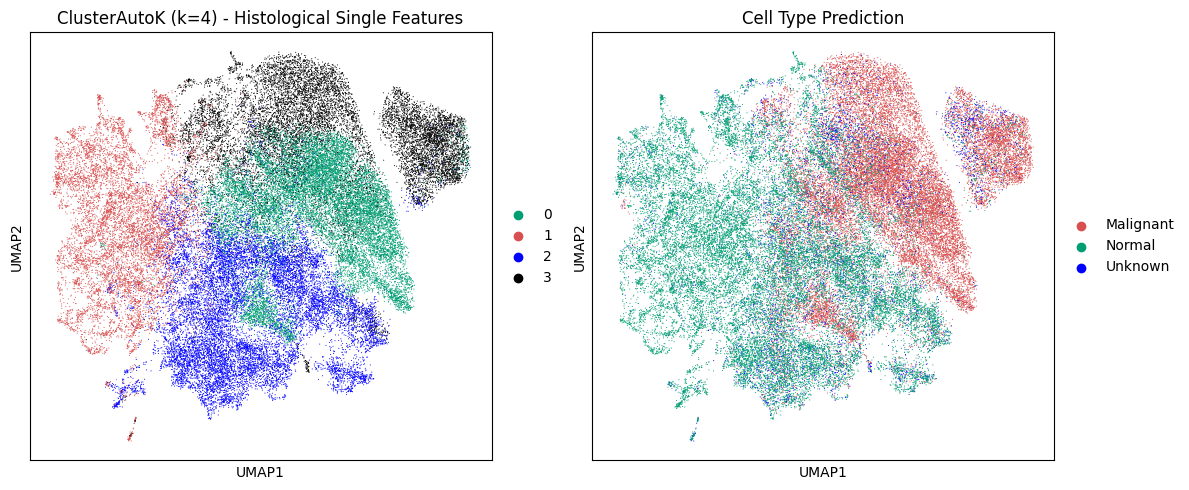

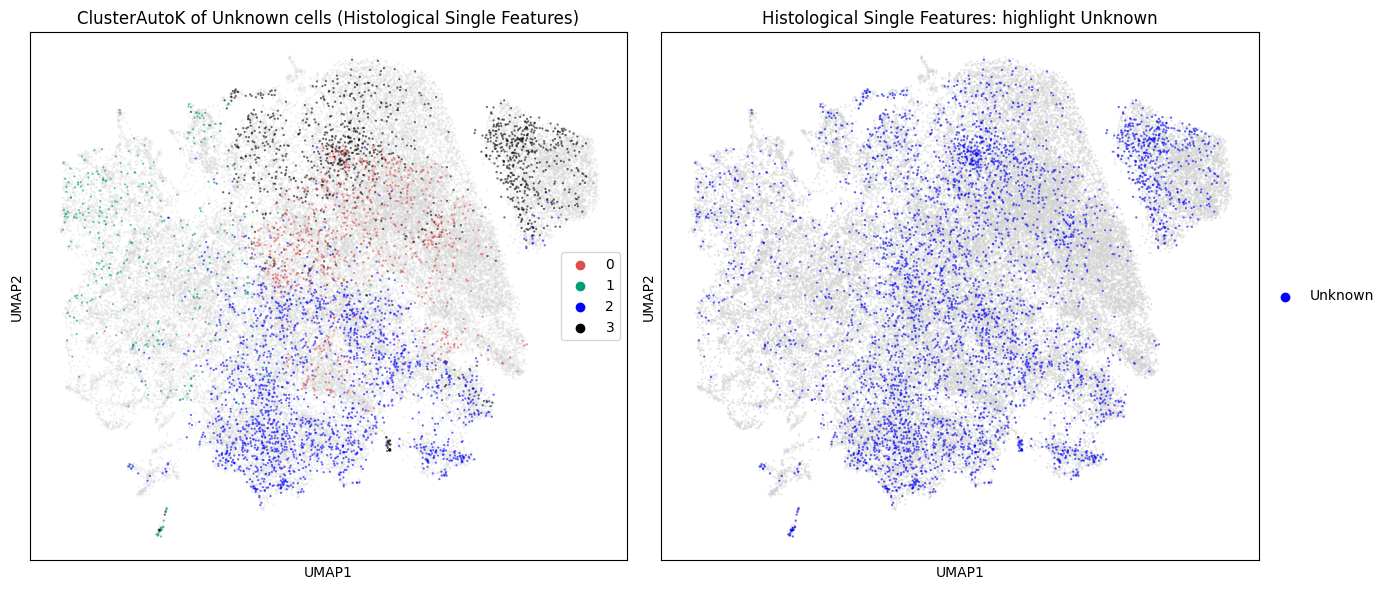

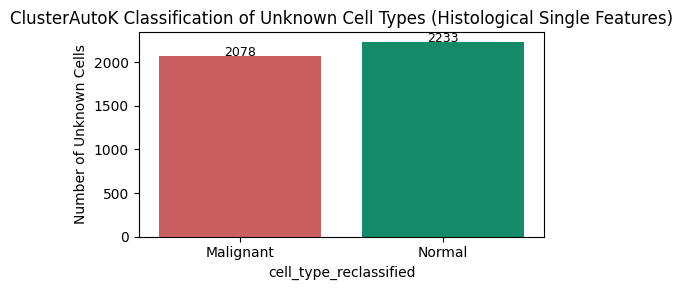

In [33]:
# Cluster counts
adata_histological_single_features_down.obs["cluster_4_scaled"].value_counts()

# Crosstab with custom labels
print(pd.crosstab(
    adata_histological_single_features_down.obs["cluster_4_scaled"],
    adata_histological_single_features_down.obs["cell_type_prediction"],
    rownames=['ClusterAutoK'],        
    colnames=['Cell Type']))

# --- UMAP: AutoK vs Cell Type Prediction ---
plot_umap_autok_vs_celltype(
    adata=adata_histological_single_features_down,
    celltype_palette={'Normal': '#009E73', 'Malignant': '#D94F4F', 'Unknown': 'blue'},
    title_left='ClusterAutoK (k=4) - Histological Single Features',
    title_right='Cell Type Prediction',
    save_path='figures/umap_autok_vs_celltype_histological_single_features_down_scaled.pdf')

# --- UMAP highlighting only Unknown cells ---
plot_autok_vs_unknown_highlight(
    adata=adata_histological_single_features_down,
    title_left='ClusterAutoK of Unknown cells (Histological Single Features)',
    title_right='Histological Single Features: highlight Unknown',
    save_path='figures/umap_histological_single_features_down_scaled_autok_vs_unknown.pdf')

# --- Reclassification of Unknown cells and countplot ---
plot_and_save_reclassified_unknowns(
    adata=adata_histological_single_features_down,
    cell_type_col='cell_type_prediction',
    unknown_label='Unknown',
    cluster_label_map={0: 'Malignant', 1: 'Normal', 2: 'Normal', 3: 'Malignant'},
    title='ClusterAutoK Classification of Unknown Cell Types (Histological Single Features)',
    save_path='figures/barplot_autok_histological_single_features_down_scaled_unknowns.pdf')

## Comparison of Histological vs Molecular Reclassification (Unknown Cells)

Molecular     Malignant  Normal
Histological                   
Malignant          1123     955
Normal              244    1989


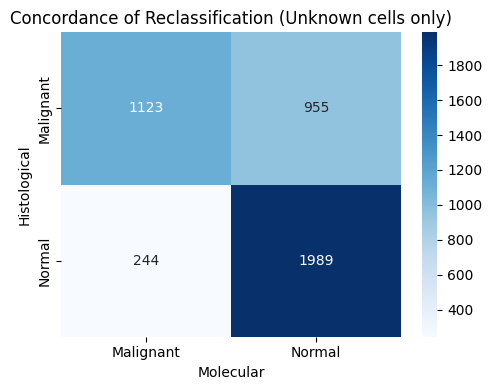

Accuracy: 0.722
Cohen's Kappa: 0.436
Adjusted Rand Index: 0.197


In [65]:
# Extract only the Unknown cells from both objects
unknown_hist = adata_histological_single_features_down.obs[
    adata_histological_single_features_down.obs["cell_type_prediction"] == "Unknown"]

unknown_mol = adata_molecular_single_features_down.obs[
    adata_molecular_single_features_down.obs["cell_type_prediction"] == "Unknown"]

# Intersection of indices for safety
common_cells = unknown_hist.index.intersection(unknown_mol.index)

# Filter both dataframes to contain only the common cell names
unknown_hist = unknown_hist.loc[common_cells]
unknown_mol = unknown_mol.loc[common_cells]

# Comparison between the two reassignments
comparison_df = pd.DataFrame({
    "Histological": unknown_hist["cell_type_reclassified"],
    "Molecular": unknown_mol["cell_type_reclassified"]})

# Contingency table
concordance_table = pd.crosstab(comparison_df["Histological"], comparison_df["Molecular"])
print(concordance_table)

plt.figure(figsize=(5, 4))
sns.heatmap(concordance_table, annot=True, fmt="d", cmap="Blues")
plt.title("Concordance of Reclassification (Unknown cells only)")
plt.xlabel("Molecular")
plt.ylabel("Histological")
plt.tight_layout()
plt.show()

acc = accuracy_score(comparison_df["Histological"], comparison_df["Molecular"])
kappa = cohen_kappa_score(comparison_df["Histological"], comparison_df["Molecular"])
ari = adjusted_rand_score(comparison_df["Histological"], comparison_df["Molecular"])

print(f"Accuracy: {acc:.3f}")
print(f"Cohen's Kappa: {kappa:.3f}")
print(f"Adjusted Rand Index: {ari:.3f}")